In [1]:
from getdata import preprocessing
from feature_engg import feature_engineering
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

import tensorflow 
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

import ta
plt.style.use('seaborn')
import warnings
warnings.filterwarnings('ignore')

In [2]:
# symbol = 'GC=F'
# price_type = 'Close'
# df_close = feature_engineering(symbol, price_type)
# print(df_close)

In [3]:
symbol = 'GC=F'
price_type = 'Close'

def build_model(symbol,price_type,split_ratio = 0.7,n_neurons = 500, n_hidden_layers = 5, epochs = 2, folder_name = None):


    df_close = feature_engineering(symbol, price_type)
    #print(df_close)
    
    split = int(split_ratio*len(df_close)) # for training

    split_test = int(0.90*len(df_close))

    # train set
    X_train = df_close[['SMA_15', 'SMA_60','MSD_10', 'MSD_30', 'rsi_14']].iloc[:split,:]
    y_train = df_close[['returns']].iloc[:split,:]
    #print(X_train.tail())

    # val dataset

    X_val = df_close[['SMA_15', 'SMA_60','MSD_10', 'MSD_30', 'rsi_14']].iloc[split:split_test,:]
    #print(X_val.tail())
    y_val = df_close[['returns']].iloc[split:split_test,:]

    # test dataset

    X_test = df_close[['SMA_15', 'SMA_60','MSD_10', 'MSD_30', 'rsi_14']].iloc[split_test:,:]
    y_test = df_close[['returns']].iloc[split_test:,:]
    #print(X_test.head())

    # data normalization

    scaler = StandardScaler()
    X_train_sc = scaler.fit_transform(X_train)
    X_val_sc = scaler.transform(X_val)
    X_test_sc = scaler.transform(X_test)



    # Initialize model

    model = Sequential()

    # first layer

    model.add(Dense(n_neurons, input_shape = (X_train_sc.shape[1],), activation = "relu"))

    # add hidden layer

    for i in range(1, n_hidden_layers):

        model.add(Dense(int(n_neurons/i), activation = "relu"))

    # output layer

    model.add(Dense(1, activation = "linear"))

    # compile the model

    model.compile(loss = 'mean_squared_error', metrics='mean_absolute_error', optimizer = Adam(learning_rate = 1e-4))
    #print(regressor.summary())
    cb = keras.callbacks.EarlyStopping(
                                    patience=10,
                                    verbose=1,
                                    )
    # training
    history = model.fit(X_train_sc, y_train, validation_data = (X_val_sc, y_val), epochs = epochs ) #callbacks = [cb]


    #plot the training and validation loss at each epoch
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)
    plt.plot(epochs, loss, 'y', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # create prediction for the whole dataset

    df_close['prediction'] = model.predict(np.concatenate((X_train_sc, X_val_sc, X_test_sc), axis = 0))

    # compute the strategy

    df_close['strategy'] = np.sign(df_close['prediction'].shift(1))* df_close['returns']

    df_close['returns'] = df_close['strategy']

    if folder_name != None:
        model.save_weights(f"../Model_Outputs/model_{folder_name}/model_parm")
        return df_close['strategy'].iloc[:split], df_close['strategy'].iloc[split:split_test], df_close['strategy'].iloc[split_test:]
    else:
        return df_close['strategy'].iloc[:split], df_close['strategy'].iloc[split:split_test], df_close['strategy'].iloc[split_test:]
    
   

    


Epoch 1/100
119/119 [==============================] - 2s 5ms/step - loss: 2.4952e-04 - mean_absolute_error: 0.0109 - val_loss: 9.6406e-05 - val_mean_absolute_error: 0.0068
Epoch 2/100
119/119 [==============================] - 0s 4ms/step - loss: 1.6238e-04 - mean_absolute_error: 0.0093 - val_loss: 1.0340e-04 - val_mean_absolute_error: 0.0068
Epoch 3/100
119/119 [==============================] - 0s 4ms/step - loss: 1.5413e-04 - mean_absolute_error: 0.0090 - val_loss: 1.1827e-04 - val_mean_absolute_error: 0.0076
Epoch 4/100
119/119 [==============================] - 0s 4ms/step - loss: 1.5632e-04 - mean_absolute_error: 0.0091 - val_loss: 1.1462e-04 - val_mean_absolute_error: 0.0077
Epoch 5/100
119/119 [==============================] - 0s 4ms/step - loss: 1.5195e-04 - mean_absolute_error: 0.0089 - val_loss: 8.8806e-05 - val_mean_absolute_error: 0.0065
Epoch 6/100
119/119 [==============================] - 0s 4ms/step - loss: 1.4599e-04 - mean_absolute_error: 0.0088 - val_loss: 1.0936e

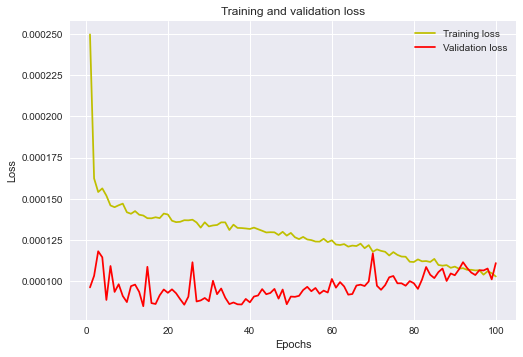

(Date
 2000-11-27         NaN
 2000-11-28   -0.001111
 2000-11-29    0.012602
 2000-11-30   -0.013889
 2000-12-01   -0.005183
                 ...   
 2016-01-22    0.001729
 2016-01-25   -0.008203
 2016-01-26    0.014012
 2016-01-27   -0.004992
 2016-01-28    0.000448
 Name: strategy, Length: 3803, dtype: float64,
 Date
 2016-01-29    0.000717
 2016-02-01   -0.010301
 2016-02-02    0.000532
 2016-02-03   -0.012419
 2016-02-04    0.014282
                 ...   
 2020-05-20    0.003669
 2020-05-21   -0.017194
 2020-05-22    0.008195
 2020-05-26   -0.017180
 2020-05-27   -0.003226
 Name: strategy, Length: 1086, dtype: float64,
 Date
 2020-05-28   -0.001754
 2020-05-29   -0.013775
 2020-06-01   -0.000518
 2020-06-02    0.007251
 2020-06-03    0.015882
                 ...   
 2022-07-18    0.003994
 2022-07-19    0.000468
 2022-07-20   -0.006140
 2022-07-21   -0.007767
 2022-07-22   -0.008408
 Name: strategy, Length: 544, dtype: float64)

In [4]:
symbol = 'GC=F'
price_type = 'Close'
split_ratio = 0.7
n_hidden_layers = 5
n_neurons = 500
epochs = 100
build_model(symbol,price_type,split_ratio, n_neurons , n_hidden_layers, epochs, folder_name = '26July2022_train')

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/100
119/119 [==============================] - 1s 6ms/step - loss: 2.0034e-04 - mean_absolute_error: 0.0104 - val_loss: 1.1416e-04 - val_mean_absolute_error: 0.0078
Epoch 2/100
119/119 [==============================] - 1s 4ms/step - loss: 1.6115e-04 - mean_absolute_error: 0.0092 - val_loss: 8.4943e-05 - val_mean_absolute_error: 0.0065
Epoch 3/100
119/119 [==============================] - 0s 4ms/step - loss: 1.6093e-04 - mean_absolute_error: 0.0092 - val_loss: 1.0722e-04 - val_mean_absolute_error: 0.0076
Epoch 4/100
119/119 [==============================] - 0s 4ms/step - loss: 1.5954e-04 - mean_absolute_error: 0.0092 - val_loss: 9.2383e-05 - val_mean_absolute_error: 0.0067
Epoch 5/100
119/119 [==============================] - 0s 4ms/step - loss: 1.5038e-04 - mean_absolute_error: 0.0089 - val_loss: 9.1675e-05 - val_mean_absolute_error: 0.0067
Epoch 6/100
119/119 [==============================] - 0s 4ms/step - loss: 1.4639e-04 - mean_absolute_error: 0.0088 - val_loss: 8.3870e

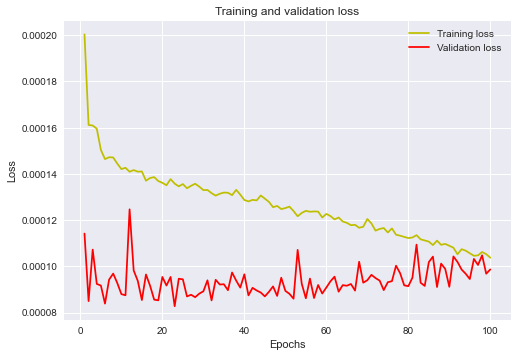

  1%|          | 1/100 [00:47<1:18:50, 47.79s/it]

Epoch 1/100
119/119 [==============================] - 1s 6ms/step - loss: 2.0303e-04 - mean_absolute_error: 0.0104 - val_loss: 1.0503e-04 - val_mean_absolute_error: 0.0075
Epoch 2/100
119/119 [==============================] - 0s 4ms/step - loss: 1.6207e-04 - mean_absolute_error: 0.0093 - val_loss: 1.0304e-04 - val_mean_absolute_error: 0.0073
Epoch 3/100
119/119 [==============================] - 0s 4ms/step - loss: 1.5534e-04 - mean_absolute_error: 0.0091 - val_loss: 9.6390e-05 - val_mean_absolute_error: 0.0071
Epoch 4/100
119/119 [==============================] - 0s 4ms/step - loss: 1.5875e-04 - mean_absolute_error: 0.0092 - val_loss: 9.2620e-05 - val_mean_absolute_error: 0.0067
Epoch 5/100
119/119 [==============================] - 0s 4ms/step - loss: 1.4577e-04 - mean_absolute_error: 0.0088 - val_loss: 9.1735e-05 - val_mean_absolute_error: 0.0068
Epoch 6/100
119/119 [==============================] - 0s 4ms/step - loss: 1.4865e-04 - mean_absolute_error: 0.0089 - val_loss: 8.4818e

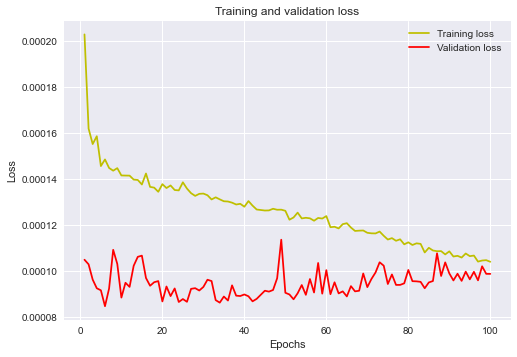

  2%|▏         | 2/100 [01:35<1:17:48, 47.64s/it]

Epoch 1/100
119/119 [==============================] - 1s 6ms/step - loss: 2.0506e-04 - mean_absolute_error: 0.0104 - val_loss: 1.1845e-04 - val_mean_absolute_error: 0.0081
Epoch 2/100
119/119 [==============================] - 1s 4ms/step - loss: 1.7182e-04 - mean_absolute_error: 0.0096 - val_loss: 9.8702e-05 - val_mean_absolute_error: 0.0072
Epoch 3/100
119/119 [==============================] - 0s 4ms/step - loss: 1.6397e-04 - mean_absolute_error: 0.0093 - val_loss: 9.9026e-05 - val_mean_absolute_error: 0.0073
Epoch 4/100
119/119 [==============================] - 0s 4ms/step - loss: 1.5613e-04 - mean_absolute_error: 0.0091 - val_loss: 8.5404e-05 - val_mean_absolute_error: 0.0065
Epoch 5/100
119/119 [==============================] - 0s 4ms/step - loss: 1.5107e-04 - mean_absolute_error: 0.0089 - val_loss: 9.1091e-05 - val_mean_absolute_error: 0.0067
Epoch 6/100
119/119 [==============================] - 0s 4ms/step - loss: 1.4935e-04 - mean_absolute_error: 0.0089 - val_loss: 1.1731e

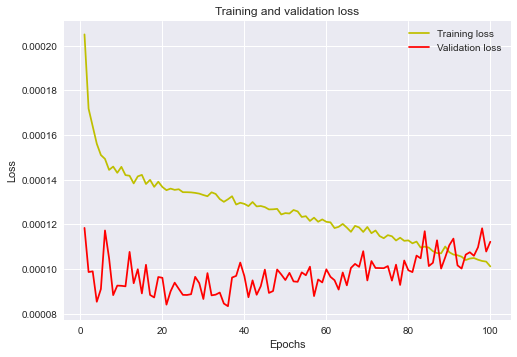

  3%|▎         | 3/100 [02:20<1:15:21, 46.61s/it]

Epoch 1/100
119/119 [==============================] - 1s 5ms/step - loss: 2.3599e-04 - mean_absolute_error: 0.0110 - val_loss: 1.1602e-04 - val_mean_absolute_error: 0.0082
Epoch 2/100
119/119 [==============================] - 1s 4ms/step - loss: 1.6388e-04 - mean_absolute_error: 0.0093 - val_loss: 8.8287e-05 - val_mean_absolute_error: 0.0066
Epoch 3/100
119/119 [==============================] - 0s 4ms/step - loss: 1.5864e-04 - mean_absolute_error: 0.0092 - val_loss: 9.6830e-05 - val_mean_absolute_error: 0.0068
Epoch 4/100
119/119 [==============================] - 0s 3ms/step - loss: 1.5455e-04 - mean_absolute_error: 0.0091 - val_loss: 9.5442e-05 - val_mean_absolute_error: 0.0067
Epoch 5/100
119/119 [==============================] - 0s 4ms/step - loss: 1.5726e-04 - mean_absolute_error: 0.0092 - val_loss: 9.8786e-05 - val_mean_absolute_error: 0.0071
Epoch 6/100
119/119 [==============================] - 0s 4ms/step - loss: 1.5178e-04 - mean_absolute_error: 0.0090 - val_loss: 9.4444e

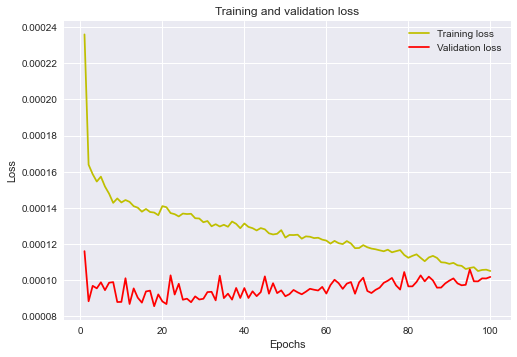

  4%|▍         | 4/100 [03:04<1:12:48, 45.50s/it]

Epoch 1/100
119/119 [==============================] - 1s 6ms/step - loss: 2.9312e-04 - mean_absolute_error: 0.0117 - val_loss: 9.8850e-05 - val_mean_absolute_error: 0.0070
Epoch 2/100
119/119 [==============================] - 0s 4ms/step - loss: 1.7511e-04 - mean_absolute_error: 0.0097 - val_loss: 1.2074e-04 - val_mean_absolute_error: 0.0080
Epoch 3/100
119/119 [==============================] - 0s 4ms/step - loss: 1.6017e-04 - mean_absolute_error: 0.0092 - val_loss: 1.3223e-04 - val_mean_absolute_error: 0.0084
Epoch 4/100
119/119 [==============================] - 0s 4ms/step - loss: 1.6371e-04 - mean_absolute_error: 0.0094 - val_loss: 1.0412e-04 - val_mean_absolute_error: 0.0070
Epoch 5/100
119/119 [==============================] - 0s 4ms/step - loss: 1.5946e-04 - mean_absolute_error: 0.0092 - val_loss: 9.9494e-05 - val_mean_absolute_error: 0.0070
Epoch 6/100
119/119 [==============================] - 0s 4ms/step - loss: 1.5342e-04 - mean_absolute_error: 0.0090 - val_loss: 1.0846e

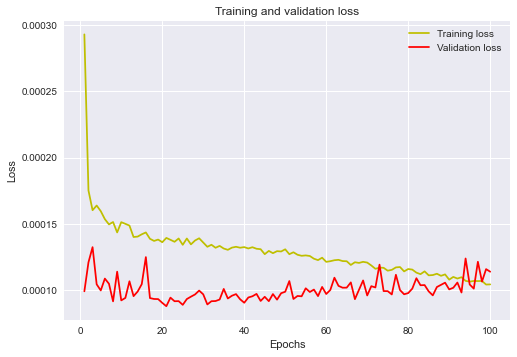

  5%|▌         | 5/100 [03:48<1:11:02, 44.87s/it]

Epoch 1/100
119/119 [==============================] - 1s 5ms/step - loss: 3.0065e-04 - mean_absolute_error: 0.0113 - val_loss: 1.0438e-04 - val_mean_absolute_error: 0.0072
Epoch 2/100
119/119 [==============================] - 0s 4ms/step - loss: 1.6244e-04 - mean_absolute_error: 0.0093 - val_loss: 1.2477e-04 - val_mean_absolute_error: 0.0076
Epoch 3/100
119/119 [==============================] - 0s 4ms/step - loss: 1.5777e-04 - mean_absolute_error: 0.0091 - val_loss: 1.0227e-04 - val_mean_absolute_error: 0.0071
Epoch 4/100
119/119 [==============================] - 0s 3ms/step - loss: 1.5964e-04 - mean_absolute_error: 0.0091 - val_loss: 9.8499e-05 - val_mean_absolute_error: 0.0070
Epoch 5/100
119/119 [==============================] - 0s 3ms/step - loss: 1.5471e-04 - mean_absolute_error: 0.0089 - val_loss: 1.2307e-04 - val_mean_absolute_error: 0.0081
Epoch 6/100
119/119 [==============================] - 0s 4ms/step - loss: 1.5090e-04 - mean_absolute_error: 0.0089 - val_loss: 1.0382e

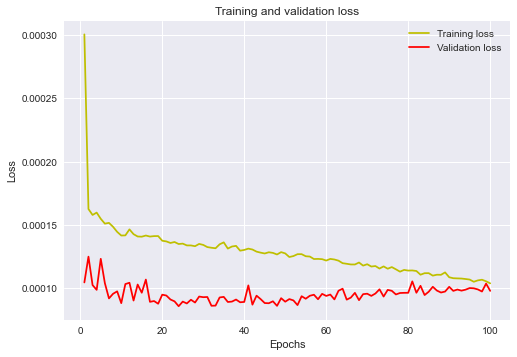

  6%|▌         | 6/100 [04:33<1:10:24, 44.94s/it]

Epoch 1/100
119/119 [==============================] - 1s 6ms/step - loss: 2.2406e-04 - mean_absolute_error: 0.0109 - val_loss: 1.3531e-04 - val_mean_absolute_error: 0.0088
Epoch 2/100
119/119 [==============================] - 0s 4ms/step - loss: 1.7832e-04 - mean_absolute_error: 0.0097 - val_loss: 1.1687e-04 - val_mean_absolute_error: 0.0080
Epoch 3/100
119/119 [==============================] - 0s 4ms/step - loss: 1.7058e-04 - mean_absolute_error: 0.0095 - val_loss: 1.3148e-04 - val_mean_absolute_error: 0.0083
Epoch 4/100
119/119 [==============================] - 0s 4ms/step - loss: 1.5801e-04 - mean_absolute_error: 0.0091 - val_loss: 9.6403e-05 - val_mean_absolute_error: 0.0069
Epoch 5/100
119/119 [==============================] - 0s 4ms/step - loss: 1.5697e-04 - mean_absolute_error: 0.0091 - val_loss: 1.2167e-04 - val_mean_absolute_error: 0.0080
Epoch 6/100
119/119 [==============================] - 0s 3ms/step - loss: 1.5073e-04 - mean_absolute_error: 0.0089 - val_loss: 1.0298e

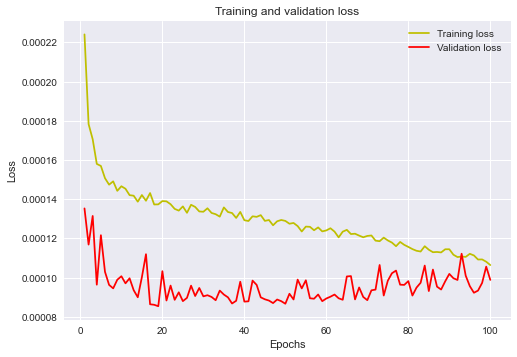

  7%|▋         | 7/100 [05:17<1:09:03, 44.56s/it]

Epoch 1/100
119/119 [==============================] - 1s 5ms/step - loss: 2.3795e-04 - mean_absolute_error: 0.0113 - val_loss: 1.3044e-04 - val_mean_absolute_error: 0.0081
Epoch 2/100
119/119 [==============================] - 0s 4ms/step - loss: 1.7816e-04 - mean_absolute_error: 0.0098 - val_loss: 1.2478e-04 - val_mean_absolute_error: 0.0075
Epoch 3/100
119/119 [==============================] - 0s 4ms/step - loss: 1.7165e-04 - mean_absolute_error: 0.0095 - val_loss: 1.0033e-04 - val_mean_absolute_error: 0.0067
Epoch 4/100
119/119 [==============================] - 0s 4ms/step - loss: 1.5547e-04 - mean_absolute_error: 0.0091 - val_loss: 1.2067e-04 - val_mean_absolute_error: 0.0079
Epoch 5/100
119/119 [==============================] - 0s 3ms/step - loss: 1.5245e-04 - mean_absolute_error: 0.0090 - val_loss: 1.2027e-04 - val_mean_absolute_error: 0.0083
Epoch 6/100
119/119 [==============================] - 0s 4ms/step - loss: 1.5404e-04 - mean_absolute_error: 0.0090 - val_loss: 9.7388e

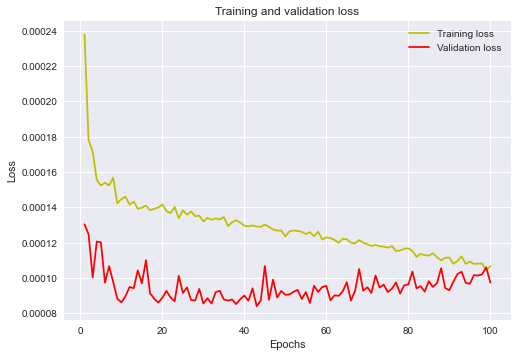

  8%|▊         | 8/100 [06:02<1:08:42, 44.81s/it]

Epoch 1/100
119/119 [==============================] - 1s 6ms/step - loss: 2.8152e-04 - mean_absolute_error: 0.0113 - val_loss: 1.0152e-04 - val_mean_absolute_error: 0.0073
Epoch 2/100
119/119 [==============================] - 0s 4ms/step - loss: 1.6107e-04 - mean_absolute_error: 0.0092 - val_loss: 1.0909e-04 - val_mean_absolute_error: 0.0071
Epoch 3/100
119/119 [==============================] - 0s 4ms/step - loss: 1.5172e-04 - mean_absolute_error: 0.0090 - val_loss: 1.0115e-04 - val_mean_absolute_error: 0.0073
Epoch 4/100
119/119 [==============================] - 0s 4ms/step - loss: 1.5082e-04 - mean_absolute_error: 0.0090 - val_loss: 1.0312e-04 - val_mean_absolute_error: 0.0073
Epoch 5/100
119/119 [==============================] - 0s 4ms/step - loss: 1.4908e-04 - mean_absolute_error: 0.0089 - val_loss: 1.1752e-04 - val_mean_absolute_error: 0.0077
Epoch 6/100
119/119 [==============================] - 0s 4ms/step - loss: 1.4619e-04 - mean_absolute_error: 0.0088 - val_loss: 9.2977e

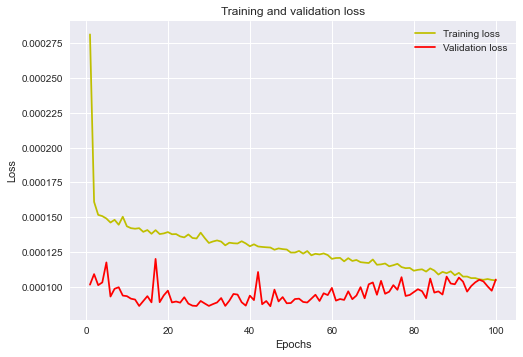

  9%|▉         | 9/100 [06:47<1:08:15, 45.01s/it]

Epoch 1/100
119/119 [==============================] - 1s 6ms/step - loss: 2.1217e-04 - mean_absolute_error: 0.0105 - val_loss: 1.1468e-04 - val_mean_absolute_error: 0.0081
Epoch 2/100
119/119 [==============================] - 1s 4ms/step - loss: 1.6543e-04 - mean_absolute_error: 0.0093 - val_loss: 1.5875e-04 - val_mean_absolute_error: 0.0096
Epoch 3/100
119/119 [==============================] - 0s 4ms/step - loss: 1.6063e-04 - mean_absolute_error: 0.0093 - val_loss: 1.1277e-04 - val_mean_absolute_error: 0.0072
Epoch 4/100
119/119 [==============================] - 0s 4ms/step - loss: 1.5815e-04 - mean_absolute_error: 0.0092 - val_loss: 1.0158e-04 - val_mean_absolute_error: 0.0073
Epoch 5/100
119/119 [==============================] - 0s 4ms/step - loss: 1.5468e-04 - mean_absolute_error: 0.0090 - val_loss: 1.0058e-04 - val_mean_absolute_error: 0.0073
Epoch 6/100
119/119 [==============================] - 0s 4ms/step - loss: 1.4859e-04 - mean_absolute_error: 0.0089 - val_loss: 1.1172e

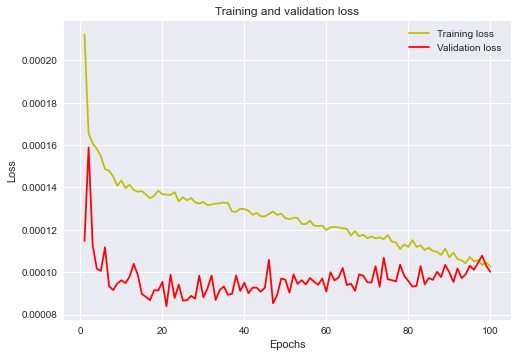

 10%|█         | 10/100 [07:33<1:07:35, 45.06s/it]

Epoch 1/100
119/119 [==============================] - 1s 5ms/step - loss: 1.9815e-04 - mean_absolute_error: 0.0103 - val_loss: 1.0212e-04 - val_mean_absolute_error: 0.0071
Epoch 2/100
119/119 [==============================] - 0s 4ms/step - loss: 1.6458e-04 - mean_absolute_error: 0.0093 - val_loss: 1.0295e-04 - val_mean_absolute_error: 0.0073
Epoch 3/100
119/119 [==============================] - 0s 4ms/step - loss: 1.6143e-04 - mean_absolute_error: 0.0092 - val_loss: 9.0727e-05 - val_mean_absolute_error: 0.0068
Epoch 4/100
119/119 [==============================] - 0s 3ms/step - loss: 1.5291e-04 - mean_absolute_error: 0.0089 - val_loss: 9.5247e-05 - val_mean_absolute_error: 0.0067
Epoch 5/100
119/119 [==============================] - 0s 3ms/step - loss: 1.5564e-04 - mean_absolute_error: 0.0091 - val_loss: 9.9381e-05 - val_mean_absolute_error: 0.0071
Epoch 6/100
119/119 [==============================] - 0s 3ms/step - loss: 1.4754e-04 - mean_absolute_error: 0.0088 - val_loss: 1.0095e

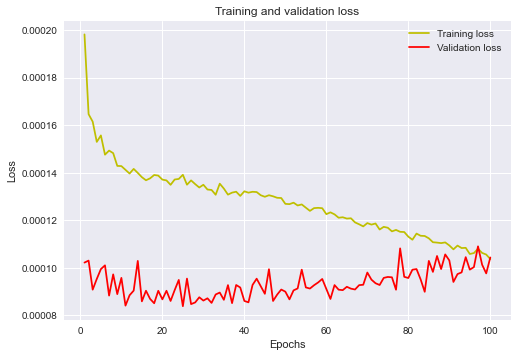

 11%|█         | 11/100 [08:16<1:06:15, 44.67s/it]

Epoch 1/100
119/119 [==============================] - 1s 6ms/step - loss: 3.7743e-04 - mean_absolute_error: 0.0127 - val_loss: 1.1087e-04 - val_mean_absolute_error: 0.0075
Epoch 2/100
119/119 [==============================] - 0s 4ms/step - loss: 1.5981e-04 - mean_absolute_error: 0.0092 - val_loss: 9.4896e-05 - val_mean_absolute_error: 0.0068
Epoch 3/100
119/119 [==============================] - 0s 3ms/step - loss: 1.6561e-04 - mean_absolute_error: 0.0093 - val_loss: 1.0079e-04 - val_mean_absolute_error: 0.0073
Epoch 4/100
119/119 [==============================] - 0s 4ms/step - loss: 1.5711e-04 - mean_absolute_error: 0.0091 - val_loss: 1.2030e-04 - val_mean_absolute_error: 0.0077
Epoch 5/100
119/119 [==============================] - 0s 3ms/step - loss: 1.5074e-04 - mean_absolute_error: 0.0089 - val_loss: 1.1628e-04 - val_mean_absolute_error: 0.0077
Epoch 6/100
119/119 [==============================] - 0s 3ms/step - loss: 1.4917e-04 - mean_absolute_error: 0.0089 - val_loss: 9.5542e

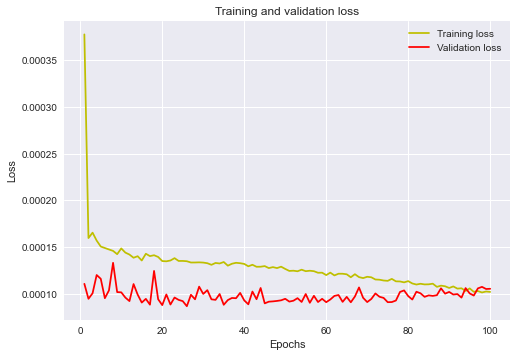

 12%|█▏        | 12/100 [09:02<1:06:06, 45.07s/it]

Epoch 1/100
119/119 [==============================] - 1s 6ms/step - loss: 2.0862e-04 - mean_absolute_error: 0.0104 - val_loss: 8.9856e-05 - val_mean_absolute_error: 0.0067
Epoch 2/100
119/119 [==============================] - 1s 4ms/step - loss: 1.5956e-04 - mean_absolute_error: 0.0092 - val_loss: 9.4518e-05 - val_mean_absolute_error: 0.0069
Epoch 3/100
119/119 [==============================] - 0s 4ms/step - loss: 1.5908e-04 - mean_absolute_error: 0.0092 - val_loss: 8.7037e-05 - val_mean_absolute_error: 0.0064
Epoch 4/100
119/119 [==============================] - 0s 4ms/step - loss: 1.5735e-04 - mean_absolute_error: 0.0091 - val_loss: 1.0123e-04 - val_mean_absolute_error: 0.0072
Epoch 5/100
119/119 [==============================] - 0s 4ms/step - loss: 1.5384e-04 - mean_absolute_error: 0.0090 - val_loss: 9.3680e-05 - val_mean_absolute_error: 0.0068
Epoch 6/100
119/119 [==============================] - 0s 4ms/step - loss: 1.5073e-04 - mean_absolute_error: 0.0088 - val_loss: 1.0105e

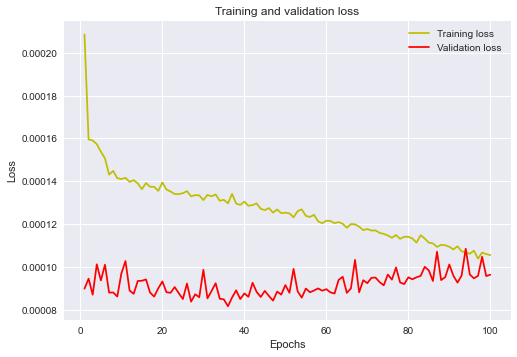

 13%|█▎        | 13/100 [09:50<1:06:33, 45.90s/it]

Epoch 1/100
119/119 [==============================] - 1s 5ms/step - loss: 2.2318e-04 - mean_absolute_error: 0.0108 - val_loss: 1.0260e-04 - val_mean_absolute_error: 0.0073
Epoch 2/100
119/119 [==============================] - 0s 4ms/step - loss: 1.6741e-04 - mean_absolute_error: 0.0094 - val_loss: 1.0009e-04 - val_mean_absolute_error: 0.0071
Epoch 3/100
119/119 [==============================] - 0s 4ms/step - loss: 1.6320e-04 - mean_absolute_error: 0.0093 - val_loss: 1.2888e-04 - val_mean_absolute_error: 0.0082
Epoch 4/100
119/119 [==============================] - 0s 4ms/step - loss: 1.6334e-04 - mean_absolute_error: 0.0093 - val_loss: 1.1305e-04 - val_mean_absolute_error: 0.0079
Epoch 5/100
119/119 [==============================] - 0s 4ms/step - loss: 1.5141e-04 - mean_absolute_error: 0.0089 - val_loss: 9.5336e-05 - val_mean_absolute_error: 0.0070
Epoch 6/100
119/119 [==============================] - 0s 4ms/step - loss: 1.5076e-04 - mean_absolute_error: 0.0090 - val_loss: 9.9398e

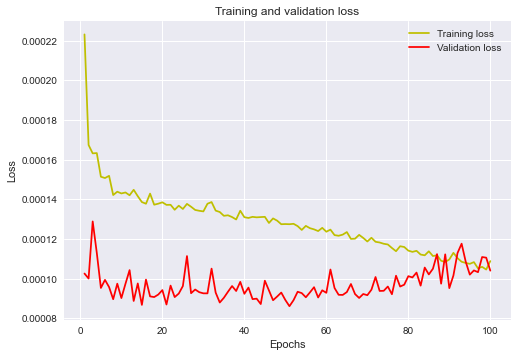

 14%|█▍        | 14/100 [10:35<1:05:27, 45.67s/it]

Epoch 1/100
119/119 [==============================] - 1s 6ms/step - loss: 1.9840e-04 - mean_absolute_error: 0.0102 - val_loss: 9.2499e-05 - val_mean_absolute_error: 0.0068
Epoch 2/100
119/119 [==============================] - 0s 4ms/step - loss: 1.6409e-04 - mean_absolute_error: 0.0093 - val_loss: 1.4446e-04 - val_mean_absolute_error: 0.0095
Epoch 3/100
119/119 [==============================] - 0s 4ms/step - loss: 1.5822e-04 - mean_absolute_error: 0.0092 - val_loss: 8.9644e-05 - val_mean_absolute_error: 0.0067
Epoch 4/100
119/119 [==============================] - 0s 4ms/step - loss: 1.4931e-04 - mean_absolute_error: 0.0088 - val_loss: 9.2300e-05 - val_mean_absolute_error: 0.0067
Epoch 5/100
119/119 [==============================] - 0s 4ms/step - loss: 1.5397e-04 - mean_absolute_error: 0.0090 - val_loss: 8.7230e-05 - val_mean_absolute_error: 0.0065
Epoch 6/100
119/119 [==============================] - 0s 4ms/step - loss: 1.4933e-04 - mean_absolute_error: 0.0088 - val_loss: 8.6326e

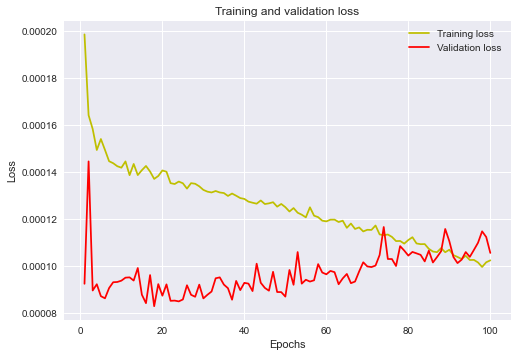

 15%|█▌        | 15/100 [11:23<1:05:44, 46.41s/it]

Epoch 1/100
119/119 [==============================] - 1s 6ms/step - loss: 3.6408e-04 - mean_absolute_error: 0.0123 - val_loss: 9.2333e-05 - val_mean_absolute_error: 0.0067
Epoch 2/100
119/119 [==============================] - 1s 4ms/step - loss: 1.5515e-04 - mean_absolute_error: 0.0090 - val_loss: 9.4384e-05 - val_mean_absolute_error: 0.0068
Epoch 3/100
119/119 [==============================] - 1s 4ms/step - loss: 1.5289e-04 - mean_absolute_error: 0.0090 - val_loss: 9.9789e-05 - val_mean_absolute_error: 0.0073
Epoch 4/100
119/119 [==============================] - 0s 4ms/step - loss: 1.5534e-04 - mean_absolute_error: 0.0091 - val_loss: 1.2719e-04 - val_mean_absolute_error: 0.0085
Epoch 5/100
119/119 [==============================] - 1s 4ms/step - loss: 1.4826e-04 - mean_absolute_error: 0.0089 - val_loss: 9.6459e-05 - val_mean_absolute_error: 0.0069
Epoch 6/100
119/119 [==============================] - 1s 4ms/step - loss: 1.4534e-04 - mean_absolute_error: 0.0087 - val_loss: 9.4573e

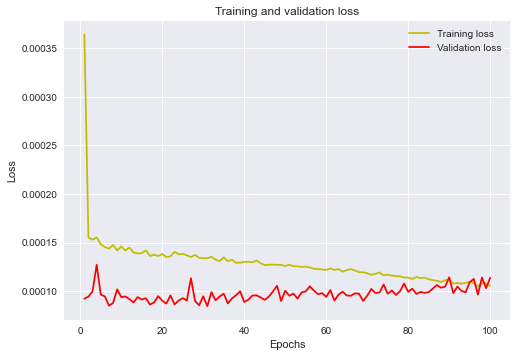

 16%|█▌        | 16/100 [12:13<1:06:21, 47.40s/it]

Epoch 1/100
119/119 [==============================] - 1s 6ms/step - loss: 2.3388e-04 - mean_absolute_error: 0.0110 - val_loss: 1.1633e-04 - val_mean_absolute_error: 0.0080
Epoch 2/100
119/119 [==============================] - 0s 4ms/step - loss: 1.6164e-04 - mean_absolute_error: 0.0092 - val_loss: 1.1043e-04 - val_mean_absolute_error: 0.0075
Epoch 3/100
119/119 [==============================] - 0s 4ms/step - loss: 1.5803e-04 - mean_absolute_error: 0.0092 - val_loss: 9.7983e-05 - val_mean_absolute_error: 0.0072
Epoch 4/100
119/119 [==============================] - 0s 3ms/step - loss: 1.5132e-04 - mean_absolute_error: 0.0089 - val_loss: 9.9221e-05 - val_mean_absolute_error: 0.0073
Epoch 5/100
119/119 [==============================] - 0s 4ms/step - loss: 1.5085e-04 - mean_absolute_error: 0.0089 - val_loss: 9.0347e-05 - val_mean_absolute_error: 0.0067
Epoch 6/100
119/119 [==============================] - 0s 4ms/step - loss: 1.5338e-04 - mean_absolute_error: 0.0090 - val_loss: 8.5138e

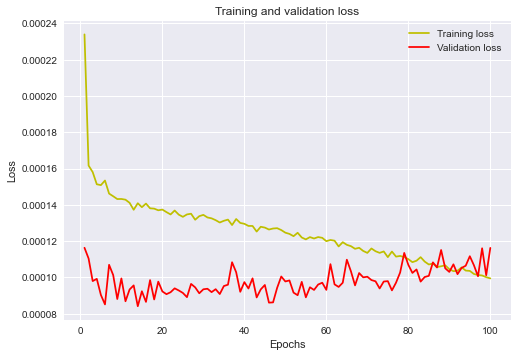

 17%|█▋        | 17/100 [12:59<1:05:00, 46.99s/it]

Epoch 1/100
119/119 [==============================] - 1s 6ms/step - loss: 3.0556e-04 - mean_absolute_error: 0.0118 - val_loss: 9.9365e-05 - val_mean_absolute_error: 0.0069
Epoch 2/100
119/119 [==============================] - 1s 4ms/step - loss: 1.5494e-04 - mean_absolute_error: 0.0090 - val_loss: 1.1723e-04 - val_mean_absolute_error: 0.0076
Epoch 3/100
119/119 [==============================] - 0s 4ms/step - loss: 1.6403e-04 - mean_absolute_error: 0.0093 - val_loss: 9.4070e-05 - val_mean_absolute_error: 0.0068
Epoch 4/100
119/119 [==============================] - 1s 4ms/step - loss: 1.5186e-04 - mean_absolute_error: 0.0090 - val_loss: 1.0679e-04 - val_mean_absolute_error: 0.0075
Epoch 5/100
119/119 [==============================] - 0s 4ms/step - loss: 1.4657e-04 - mean_absolute_error: 0.0088 - val_loss: 1.0493e-04 - val_mean_absolute_error: 0.0070
Epoch 6/100
119/119 [==============================] - 0s 4ms/step - loss: 1.4731e-04 - mean_absolute_error: 0.0088 - val_loss: 1.1122e

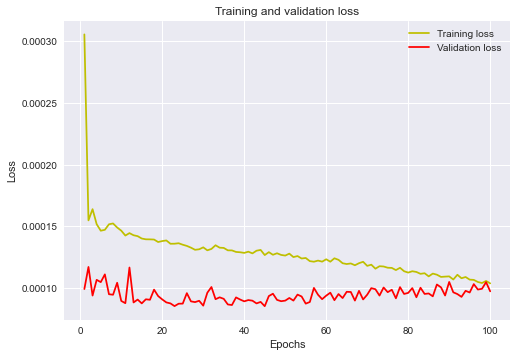

 18%|█▊        | 18/100 [13:47<1:04:25, 47.14s/it]

Epoch 1/100
119/119 [==============================] - 1s 6ms/step - loss: 2.2110e-04 - mean_absolute_error: 0.0106 - val_loss: 1.1508e-04 - val_mean_absolute_error: 0.0079
Epoch 2/100
119/119 [==============================] - 0s 4ms/step - loss: 1.6907e-04 - mean_absolute_error: 0.0095 - val_loss: 1.0019e-04 - val_mean_absolute_error: 0.0073
Epoch 3/100
119/119 [==============================] - 0s 4ms/step - loss: 1.7068e-04 - mean_absolute_error: 0.0095 - val_loss: 9.2562e-05 - val_mean_absolute_error: 0.0066
Epoch 4/100
119/119 [==============================] - 0s 4ms/step - loss: 1.5501e-04 - mean_absolute_error: 0.0091 - val_loss: 1.1657e-04 - val_mean_absolute_error: 0.0079
Epoch 5/100
119/119 [==============================] - 0s 4ms/step - loss: 1.5173e-04 - mean_absolute_error: 0.0090 - val_loss: 1.0404e-04 - val_mean_absolute_error: 0.0071
Epoch 6/100
119/119 [==============================] - 0s 4ms/step - loss: 1.4625e-04 - mean_absolute_error: 0.0088 - val_loss: 9.0012e

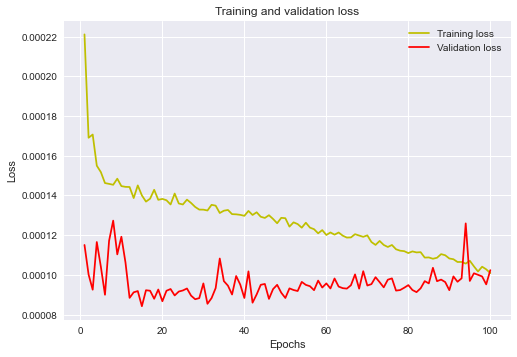

 19%|█▉        | 19/100 [14:33<1:03:19, 46.91s/it]

Epoch 1/100
119/119 [==============================] - 1s 7ms/step - loss: 1.9995e-04 - mean_absolute_error: 0.0102 - val_loss: 1.0180e-04 - val_mean_absolute_error: 0.0071
Epoch 2/100
119/119 [==============================] - 1s 5ms/step - loss: 1.6123e-04 - mean_absolute_error: 0.0092 - val_loss: 1.0183e-04 - val_mean_absolute_error: 0.0070
Epoch 3/100
119/119 [==============================] - 1s 4ms/step - loss: 1.5566e-04 - mean_absolute_error: 0.0091 - val_loss: 8.7773e-05 - val_mean_absolute_error: 0.0066
Epoch 4/100
119/119 [==============================] - 1s 4ms/step - loss: 1.5372e-04 - mean_absolute_error: 0.0089 - val_loss: 9.4262e-05 - val_mean_absolute_error: 0.0069
Epoch 5/100
119/119 [==============================] - 1s 4ms/step - loss: 1.4829e-04 - mean_absolute_error: 0.0088 - val_loss: 9.2202e-05 - val_mean_absolute_error: 0.0066
Epoch 6/100
119/119 [==============================] - 1s 5ms/step - loss: 1.4975e-04 - mean_absolute_error: 0.0088 - val_loss: 9.1474e

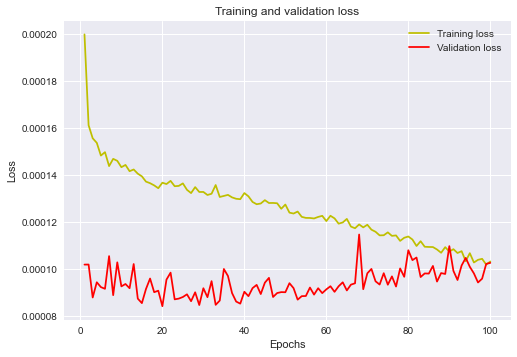

 20%|██        | 20/100 [15:25<1:04:37, 48.47s/it]

Epoch 1/100
119/119 [==============================] - 1s 7ms/step - loss: 2.0475e-04 - mean_absolute_error: 0.0104 - val_loss: 1.0819e-04 - val_mean_absolute_error: 0.0074
Epoch 2/100
119/119 [==============================] - 1s 5ms/step - loss: 1.6892e-04 - mean_absolute_error: 0.0094 - val_loss: 8.8857e-05 - val_mean_absolute_error: 0.0066
Epoch 3/100
119/119 [==============================] - 1s 5ms/step - loss: 1.6596e-04 - mean_absolute_error: 0.0094 - val_loss: 1.2651e-04 - val_mean_absolute_error: 0.0084
Epoch 4/100
119/119 [==============================] - 1s 4ms/step - loss: 1.5209e-04 - mean_absolute_error: 0.0089 - val_loss: 1.3738e-04 - val_mean_absolute_error: 0.0088
Epoch 5/100
119/119 [==============================] - 1s 4ms/step - loss: 1.5092e-04 - mean_absolute_error: 0.0089 - val_loss: 9.3598e-05 - val_mean_absolute_error: 0.0067
Epoch 6/100
119/119 [==============================] - 1s 5ms/step - loss: 1.5205e-04 - mean_absolute_error: 0.0089 - val_loss: 1.0611e

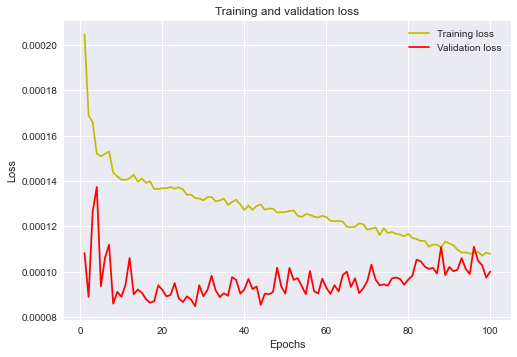

 21%|██        | 21/100 [16:19<1:05:47, 49.96s/it]

Epoch 1/100
119/119 [==============================] - 1s 6ms/step - loss: 2.1727e-04 - mean_absolute_error: 0.0104 - val_loss: 9.3098e-05 - val_mean_absolute_error: 0.0068
Epoch 2/100
119/119 [==============================] - 1s 4ms/step - loss: 1.6253e-04 - mean_absolute_error: 0.0093 - val_loss: 1.1948e-04 - val_mean_absolute_error: 0.0083
Epoch 3/100
119/119 [==============================] - 1s 4ms/step - loss: 1.6026e-04 - mean_absolute_error: 0.0093 - val_loss: 9.0749e-05 - val_mean_absolute_error: 0.0067
Epoch 4/100
119/119 [==============================] - 0s 4ms/step - loss: 1.5329e-04 - mean_absolute_error: 0.0091 - val_loss: 9.9322e-05 - val_mean_absolute_error: 0.0073
Epoch 5/100
119/119 [==============================] - 0s 4ms/step - loss: 1.5359e-04 - mean_absolute_error: 0.0090 - val_loss: 9.3072e-05 - val_mean_absolute_error: 0.0068
Epoch 6/100
119/119 [==============================] - 0s 4ms/step - loss: 1.4641e-04 - mean_absolute_error: 0.0088 - val_loss: 9.0188e

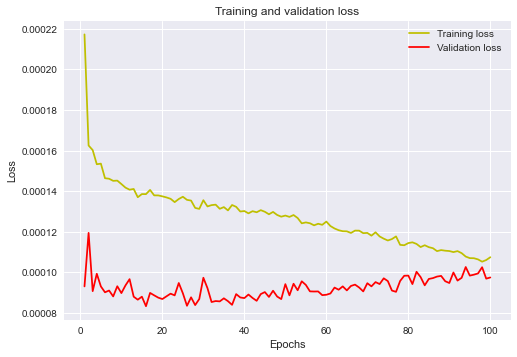

 22%|██▏       | 22/100 [17:08<1:04:37, 49.71s/it]

Epoch 1/100
119/119 [==============================] - 1s 6ms/step - loss: 2.3555e-04 - mean_absolute_error: 0.0110 - val_loss: 1.0204e-04 - val_mean_absolute_error: 0.0074
Epoch 2/100
119/119 [==============================] - 0s 4ms/step - loss: 1.6263e-04 - mean_absolute_error: 0.0093 - val_loss: 1.0358e-04 - val_mean_absolute_error: 0.0073
Epoch 3/100
119/119 [==============================] - 0s 4ms/step - loss: 1.5696e-04 - mean_absolute_error: 0.0092 - val_loss: 1.0448e-04 - val_mean_absolute_error: 0.0070
Epoch 4/100
119/119 [==============================] - 0s 4ms/step - loss: 1.5325e-04 - mean_absolute_error: 0.0090 - val_loss: 1.0383e-04 - val_mean_absolute_error: 0.0072
Epoch 5/100
119/119 [==============================] - 0s 3ms/step - loss: 1.5707e-04 - mean_absolute_error: 0.0091 - val_loss: 9.2429e-05 - val_mean_absolute_error: 0.0069
Epoch 6/100
119/119 [==============================] - 0s 4ms/step - loss: 1.4550e-04 - mean_absolute_error: 0.0088 - val_loss: 9.8847e

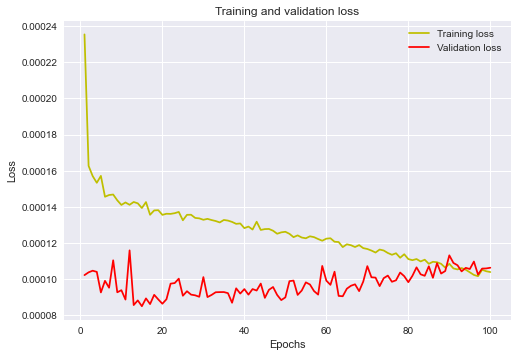

 23%|██▎       | 23/100 [17:55<1:02:42, 48.86s/it]

Epoch 1/100
119/119 [==============================] - 1s 6ms/step - loss: 2.7072e-04 - mean_absolute_error: 0.0115 - val_loss: 1.0362e-04 - val_mean_absolute_error: 0.0075
Epoch 2/100
119/119 [==============================] - 1s 4ms/step - loss: 1.5649e-04 - mean_absolute_error: 0.0091 - val_loss: 9.5531e-05 - val_mean_absolute_error: 0.0070
Epoch 3/100
119/119 [==============================] - 0s 4ms/step - loss: 1.5598e-04 - mean_absolute_error: 0.0091 - val_loss: 1.0092e-04 - val_mean_absolute_error: 0.0070
Epoch 4/100
119/119 [==============================] - 0s 4ms/step - loss: 1.4789e-04 - mean_absolute_error: 0.0088 - val_loss: 9.0840e-05 - val_mean_absolute_error: 0.0065
Epoch 5/100
119/119 [==============================] - 0s 4ms/step - loss: 1.4995e-04 - mean_absolute_error: 0.0089 - val_loss: 9.7743e-05 - val_mean_absolute_error: 0.0072
Epoch 6/100
119/119 [==============================] - 0s 4ms/step - loss: 1.4528e-04 - mean_absolute_error: 0.0088 - val_loss: 1.0733e

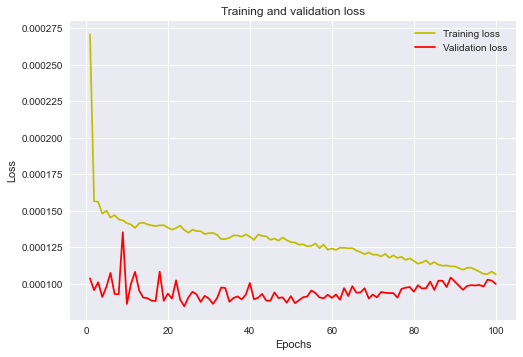

 24%|██▍       | 24/100 [18:42<1:01:25, 48.49s/it]

Epoch 1/100
119/119 [==============================] - 1s 6ms/step - loss: 2.1697e-04 - mean_absolute_error: 0.0109 - val_loss: 1.3231e-04 - val_mean_absolute_error: 0.0084
Epoch 2/100
119/119 [==============================] - 0s 4ms/step - loss: 1.7595e-04 - mean_absolute_error: 0.0097 - val_loss: 1.0789e-04 - val_mean_absolute_error: 0.0075
Epoch 3/100
119/119 [==============================] - 0s 4ms/step - loss: 1.5552e-04 - mean_absolute_error: 0.0091 - val_loss: 1.0763e-04 - val_mean_absolute_error: 0.0076
Epoch 4/100
119/119 [==============================] - 0s 4ms/step - loss: 1.5395e-04 - mean_absolute_error: 0.0090 - val_loss: 9.3042e-05 - val_mean_absolute_error: 0.0066
Epoch 5/100
119/119 [==============================] - 0s 4ms/step - loss: 1.5106e-04 - mean_absolute_error: 0.0089 - val_loss: 9.9750e-05 - val_mean_absolute_error: 0.0072
Epoch 6/100
119/119 [==============================] - 0s 4ms/step - loss: 1.4544e-04 - mean_absolute_error: 0.0088 - val_loss: 1.0560e

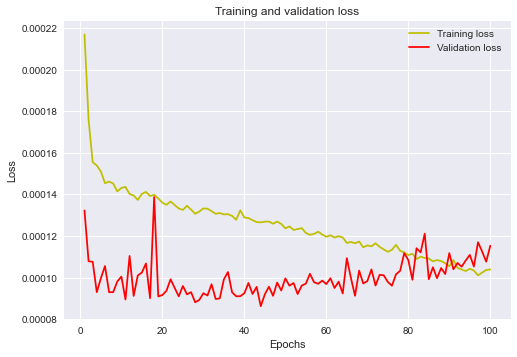

 25%|██▌       | 25/100 [19:29<59:51, 47.89s/it]  

Epoch 1/100
119/119 [==============================] - 1s 7ms/step - loss: 2.1787e-04 - mean_absolute_error: 0.0107 - val_loss: 1.4199e-04 - val_mean_absolute_error: 0.0092
Epoch 2/100
119/119 [==============================] - 1s 5ms/step - loss: 1.6268e-04 - mean_absolute_error: 0.0093 - val_loss: 1.0024e-04 - val_mean_absolute_error: 0.0070
Epoch 3/100
119/119 [==============================] - 1s 4ms/step - loss: 1.5440e-04 - mean_absolute_error: 0.0091 - val_loss: 9.9782e-05 - val_mean_absolute_error: 0.0068
Epoch 4/100
119/119 [==============================] - 0s 4ms/step - loss: 1.5159e-04 - mean_absolute_error: 0.0089 - val_loss: 9.2131e-05 - val_mean_absolute_error: 0.0066
Epoch 5/100
119/119 [==============================] - 0s 4ms/step - loss: 1.5046e-04 - mean_absolute_error: 0.0089 - val_loss: 1.0105e-04 - val_mean_absolute_error: 0.0072
Epoch 6/100
119/119 [==============================] - 0s 4ms/step - loss: 1.5056e-04 - mean_absolute_error: 0.0088 - val_loss: 9.5442e

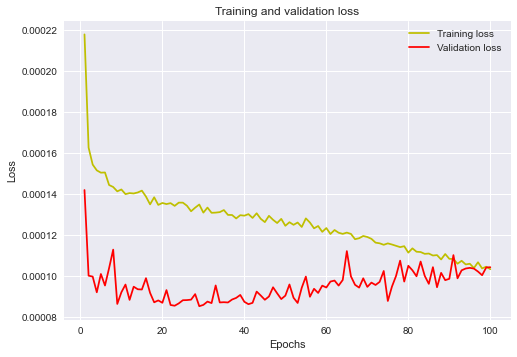

 26%|██▌       | 26/100 [20:17<59:06, 47.92s/it]

Epoch 1/100
119/119 [==============================] - 1s 6ms/step - loss: 2.3131e-04 - mean_absolute_error: 0.0108 - val_loss: 1.0734e-04 - val_mean_absolute_error: 0.0075
Epoch 2/100
119/119 [==============================] - 0s 4ms/step - loss: 1.5667e-04 - mean_absolute_error: 0.0091 - val_loss: 1.0729e-04 - val_mean_absolute_error: 0.0076
Epoch 3/100
119/119 [==============================] - 0s 4ms/step - loss: 1.5756e-04 - mean_absolute_error: 0.0092 - val_loss: 9.2966e-05 - val_mean_absolute_error: 0.0068
Epoch 4/100
119/119 [==============================] - 0s 4ms/step - loss: 1.5642e-04 - mean_absolute_error: 0.0091 - val_loss: 1.0894e-04 - val_mean_absolute_error: 0.0075
Epoch 5/100
119/119 [==============================] - 0s 4ms/step - loss: 1.5510e-04 - mean_absolute_error: 0.0090 - val_loss: 9.4562e-05 - val_mean_absolute_error: 0.0067
Epoch 6/100
119/119 [==============================] - 0s 4ms/step - loss: 1.4740e-04 - mean_absolute_error: 0.0088 - val_loss: 8.7280e

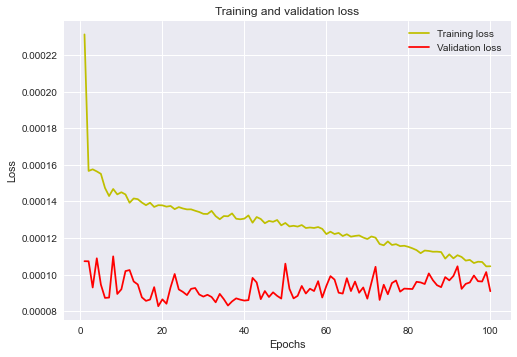

 27%|██▋       | 27/100 [21:03<57:36, 47.34s/it]

Epoch 1/100
119/119 [==============================] - 1s 6ms/step - loss: 2.0600e-04 - mean_absolute_error: 0.0103 - val_loss: 1.0340e-04 - val_mean_absolute_error: 0.0073
Epoch 2/100
119/119 [==============================] - 1s 4ms/step - loss: 1.6211e-04 - mean_absolute_error: 0.0093 - val_loss: 1.2025e-04 - val_mean_absolute_error: 0.0082
Epoch 3/100
119/119 [==============================] - 0s 4ms/step - loss: 1.5225e-04 - mean_absolute_error: 0.0090 - val_loss: 1.0446e-04 - val_mean_absolute_error: 0.0074
Epoch 4/100
119/119 [==============================] - 0s 4ms/step - loss: 1.5181e-04 - mean_absolute_error: 0.0089 - val_loss: 9.4201e-05 - val_mean_absolute_error: 0.0067
Epoch 5/100
119/119 [==============================] - 0s 3ms/step - loss: 1.4630e-04 - mean_absolute_error: 0.0088 - val_loss: 9.0806e-05 - val_mean_absolute_error: 0.0066
Epoch 6/100
119/119 [==============================] - 0s 4ms/step - loss: 1.4769e-04 - mean_absolute_error: 0.0088 - val_loss: 8.7344e

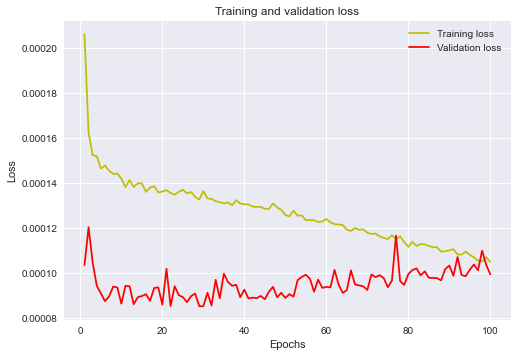

 28%|██▊       | 28/100 [21:48<56:10, 46.82s/it]

Epoch 1/100
119/119 [==============================] - 1s 6ms/step - loss: 2.4975e-04 - mean_absolute_error: 0.0113 - val_loss: 1.2105e-04 - val_mean_absolute_error: 0.0076
Epoch 2/100
119/119 [==============================] - 0s 4ms/step - loss: 1.7571e-04 - mean_absolute_error: 0.0095 - val_loss: 1.0592e-04 - val_mean_absolute_error: 0.0071
Epoch 3/100
119/119 [==============================] - 0s 4ms/step - loss: 1.6113e-04 - mean_absolute_error: 0.0092 - val_loss: 1.0400e-04 - val_mean_absolute_error: 0.0073
Epoch 4/100
119/119 [==============================] - 0s 4ms/step - loss: 1.5778e-04 - mean_absolute_error: 0.0092 - val_loss: 9.9450e-05 - val_mean_absolute_error: 0.0071
Epoch 5/100
119/119 [==============================] - 0s 4ms/step - loss: 1.5579e-04 - mean_absolute_error: 0.0091 - val_loss: 9.0107e-05 - val_mean_absolute_error: 0.0067
Epoch 6/100
119/119 [==============================] - 0s 4ms/step - loss: 1.5761e-04 - mean_absolute_error: 0.0090 - val_loss: 9.9014e

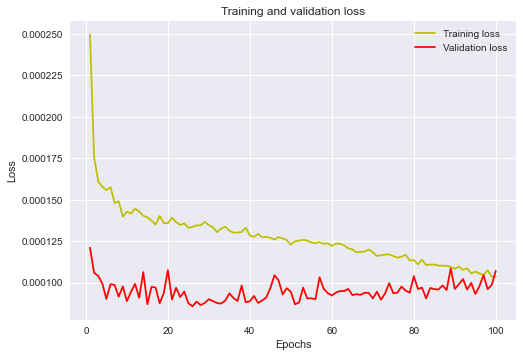

 29%|██▉       | 29/100 [22:35<55:15, 46.70s/it]

Epoch 1/100
119/119 [==============================] - 1s 5ms/step - loss: 2.1999e-04 - mean_absolute_error: 0.0107 - val_loss: 1.1282e-04 - val_mean_absolute_error: 0.0075
Epoch 2/100
119/119 [==============================] - 0s 3ms/step - loss: 1.6722e-04 - mean_absolute_error: 0.0095 - val_loss: 9.4546e-05 - val_mean_absolute_error: 0.0068
Epoch 3/100
119/119 [==============================] - 0s 3ms/step - loss: 1.6680e-04 - mean_absolute_error: 0.0094 - val_loss: 1.4367e-04 - val_mean_absolute_error: 0.0085
Epoch 4/100
119/119 [==============================] - 0s 4ms/step - loss: 1.7284e-04 - mean_absolute_error: 0.0095 - val_loss: 9.9804e-05 - val_mean_absolute_error: 0.0069
Epoch 5/100
119/119 [==============================] - 0s 4ms/step - loss: 1.4793e-04 - mean_absolute_error: 0.0088 - val_loss: 1.0999e-04 - val_mean_absolute_error: 0.0070
Epoch 6/100
119/119 [==============================] - 0s 4ms/step - loss: 1.5248e-04 - mean_absolute_error: 0.0090 - val_loss: 9.3216e

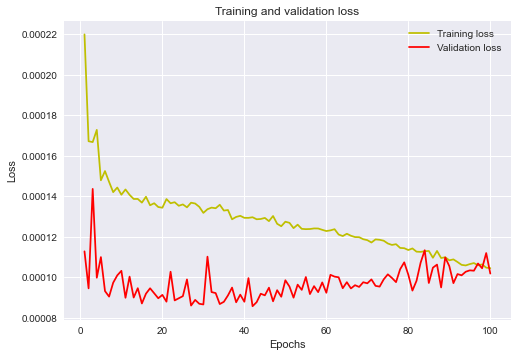

 30%|███       | 30/100 [23:20<53:56, 46.24s/it]

Epoch 1/100
119/119 [==============================] - 1s 6ms/step - loss: 3.2276e-04 - mean_absolute_error: 0.0119 - val_loss: 9.2896e-05 - val_mean_absolute_error: 0.0067
Epoch 2/100
119/119 [==============================] - 0s 4ms/step - loss: 1.5502e-04 - mean_absolute_error: 0.0090 - val_loss: 1.2702e-04 - val_mean_absolute_error: 0.0086
Epoch 3/100
119/119 [==============================] - 0s 4ms/step - loss: 1.5032e-04 - mean_absolute_error: 0.0089 - val_loss: 1.0422e-04 - val_mean_absolute_error: 0.0071
Epoch 4/100
119/119 [==============================] - 0s 4ms/step - loss: 1.4985e-04 - mean_absolute_error: 0.0090 - val_loss: 1.3293e-04 - val_mean_absolute_error: 0.0087
Epoch 5/100
119/119 [==============================] - 0s 4ms/step - loss: 1.5082e-04 - mean_absolute_error: 0.0090 - val_loss: 1.1698e-04 - val_mean_absolute_error: 0.0078
Epoch 6/100
119/119 [==============================] - 0s 4ms/step - loss: 1.4623e-04 - mean_absolute_error: 0.0088 - val_loss: 9.4807e

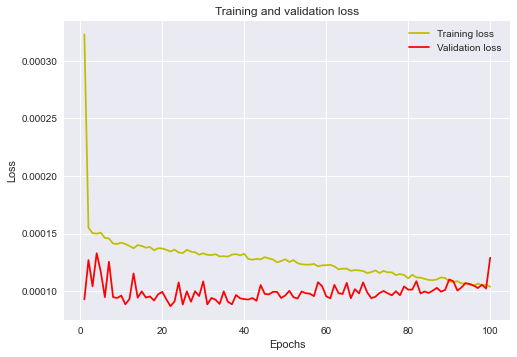

 31%|███       | 31/100 [24:05<52:49, 45.94s/it]

Epoch 1/100
119/119 [==============================] - 1s 5ms/step - loss: 2.2635e-04 - mean_absolute_error: 0.0108 - val_loss: 9.8607e-05 - val_mean_absolute_error: 0.0071
Epoch 2/100
119/119 [==============================] - 0s 4ms/step - loss: 1.7076e-04 - mean_absolute_error: 0.0095 - val_loss: 1.2035e-04 - val_mean_absolute_error: 0.0080
Epoch 3/100
119/119 [==============================] - 0s 4ms/step - loss: 1.5391e-04 - mean_absolute_error: 0.0090 - val_loss: 9.5776e-05 - val_mean_absolute_error: 0.0070
Epoch 4/100
119/119 [==============================] - 0s 3ms/step - loss: 1.5402e-04 - mean_absolute_error: 0.0090 - val_loss: 1.1728e-04 - val_mean_absolute_error: 0.0077
Epoch 5/100
119/119 [==============================] - 0s 3ms/step - loss: 1.5392e-04 - mean_absolute_error: 0.0090 - val_loss: 1.0024e-04 - val_mean_absolute_error: 0.0072
Epoch 6/100
119/119 [==============================] - 0s 3ms/step - loss: 1.4877e-04 - mean_absolute_error: 0.0088 - val_loss: 9.2247e

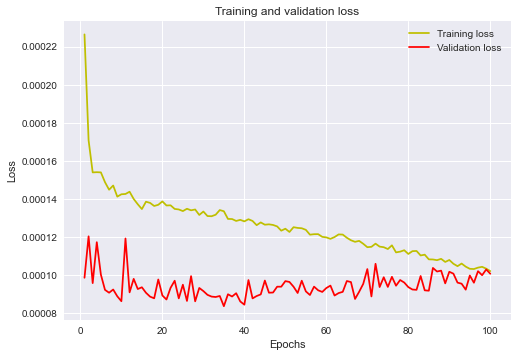

 32%|███▏      | 32/100 [24:48<50:59, 44.99s/it]

Epoch 1/100
119/119 [==============================] - 1s 6ms/step - loss: 2.1500e-04 - mean_absolute_error: 0.0106 - val_loss: 1.0609e-04 - val_mean_absolute_error: 0.0074
Epoch 2/100
119/119 [==============================] - 0s 4ms/step - loss: 1.5664e-04 - mean_absolute_error: 0.0092 - val_loss: 9.8021e-05 - val_mean_absolute_error: 0.0073
Epoch 3/100
119/119 [==============================] - 0s 4ms/step - loss: 1.6027e-04 - mean_absolute_error: 0.0092 - val_loss: 1.0490e-04 - val_mean_absolute_error: 0.0074
Epoch 4/100
119/119 [==============================] - 0s 4ms/step - loss: 1.5438e-04 - mean_absolute_error: 0.0090 - val_loss: 9.8212e-05 - val_mean_absolute_error: 0.0071
Epoch 5/100
119/119 [==============================] - 0s 3ms/step - loss: 1.5079e-04 - mean_absolute_error: 0.0088 - val_loss: 1.0465e-04 - val_mean_absolute_error: 0.0069
Epoch 6/100
119/119 [==============================] - 0s 3ms/step - loss: 1.5053e-04 - mean_absolute_error: 0.0088 - val_loss: 9.0738e

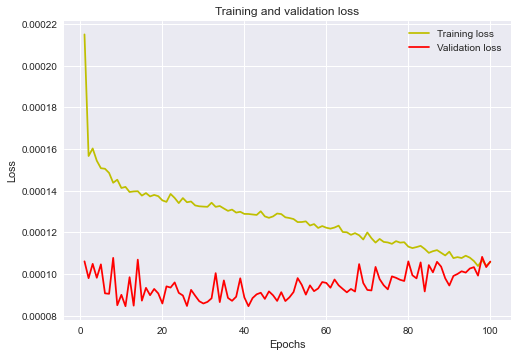

 33%|███▎      | 33/100 [25:31<49:36, 44.43s/it]

Epoch 1/100
119/119 [==============================] - 1s 6ms/step - loss: 5.4274e-04 - mean_absolute_error: 0.0142 - val_loss: 8.8277e-05 - val_mean_absolute_error: 0.0066
Epoch 2/100
119/119 [==============================] - 0s 4ms/step - loss: 1.5607e-04 - mean_absolute_error: 0.0091 - val_loss: 9.8182e-05 - val_mean_absolute_error: 0.0066
Epoch 3/100
119/119 [==============================] - 0s 4ms/step - loss: 1.4769e-04 - mean_absolute_error: 0.0088 - val_loss: 9.2002e-05 - val_mean_absolute_error: 0.0065
Epoch 4/100
119/119 [==============================] - 0s 4ms/step - loss: 1.5247e-04 - mean_absolute_error: 0.0089 - val_loss: 1.2055e-04 - val_mean_absolute_error: 0.0076
Epoch 5/100
119/119 [==============================] - 0s 3ms/step - loss: 1.5299e-04 - mean_absolute_error: 0.0090 - val_loss: 1.1951e-04 - val_mean_absolute_error: 0.0080
Epoch 6/100
119/119 [==============================] - 0s 3ms/step - loss: 1.4606e-04 - mean_absolute_error: 0.0088 - val_loss: 1.0451e

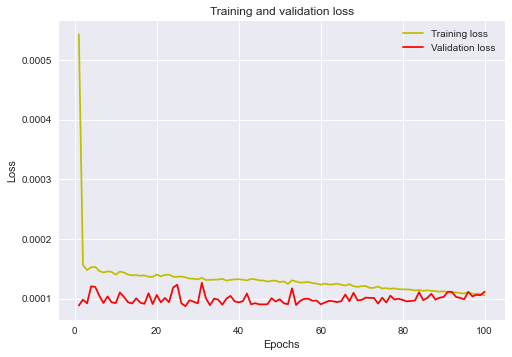

 34%|███▍      | 34/100 [26:15<48:38, 44.22s/it]

Epoch 1/100
119/119 [==============================] - 1s 5ms/step - loss: 1.9314e-04 - mean_absolute_error: 0.0101 - val_loss: 1.2256e-04 - val_mean_absolute_error: 0.0082
Epoch 2/100
119/119 [==============================] - 0s 4ms/step - loss: 1.6283e-04 - mean_absolute_error: 0.0094 - val_loss: 8.8893e-05 - val_mean_absolute_error: 0.0067
Epoch 3/100
119/119 [==============================] - 0s 4ms/step - loss: 1.5901e-04 - mean_absolute_error: 0.0091 - val_loss: 8.9657e-05 - val_mean_absolute_error: 0.0064
Epoch 4/100
119/119 [==============================] - 0s 4ms/step - loss: 1.5229e-04 - mean_absolute_error: 0.0090 - val_loss: 1.0705e-04 - val_mean_absolute_error: 0.0073
Epoch 5/100
119/119 [==============================] - 0s 4ms/step - loss: 1.5252e-04 - mean_absolute_error: 0.0089 - val_loss: 9.7897e-05 - val_mean_absolute_error: 0.0069
Epoch 6/100
119/119 [==============================] - 0s 3ms/step - loss: 1.5121e-04 - mean_absolute_error: 0.0090 - val_loss: 9.1124e

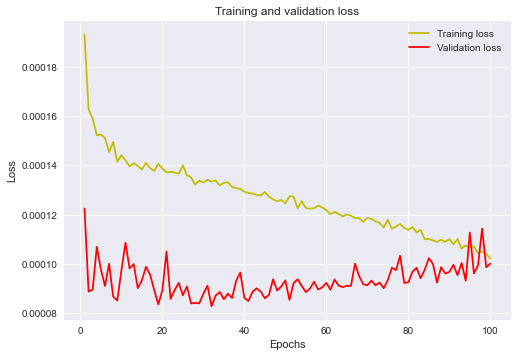

 35%|███▌      | 35/100 [26:58<47:37, 43.96s/it]

Epoch 1/100
119/119 [==============================] - 1s 6ms/step - loss: 2.4040e-04 - mean_absolute_error: 0.0108 - val_loss: 1.1322e-04 - val_mean_absolute_error: 0.0077
Epoch 2/100
119/119 [==============================] - 0s 4ms/step - loss: 1.6993e-04 - mean_absolute_error: 0.0094 - val_loss: 1.0749e-04 - val_mean_absolute_error: 0.0076
Epoch 3/100
119/119 [==============================] - 0s 4ms/step - loss: 1.5315e-04 - mean_absolute_error: 0.0090 - val_loss: 9.6150e-05 - val_mean_absolute_error: 0.0070
Epoch 4/100
119/119 [==============================] - 0s 4ms/step - loss: 1.5171e-04 - mean_absolute_error: 0.0089 - val_loss: 8.6910e-05 - val_mean_absolute_error: 0.0065
Epoch 5/100
119/119 [==============================] - 0s 3ms/step - loss: 1.5233e-04 - mean_absolute_error: 0.0090 - val_loss: 8.9516e-05 - val_mean_absolute_error: 0.0067
Epoch 6/100
119/119 [==============================] - 0s 3ms/step - loss: 1.5267e-04 - mean_absolute_error: 0.0089 - val_loss: 9.0361e

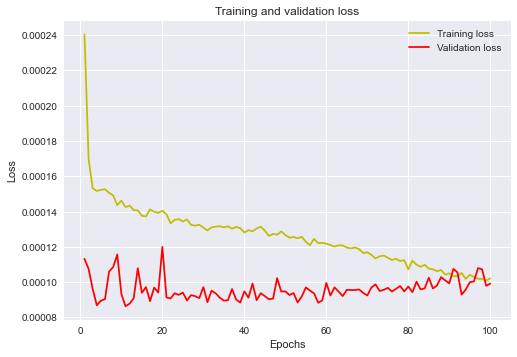

 36%|███▌      | 36/100 [27:42<46:46, 43.85s/it]

Epoch 1/100
119/119 [==============================] - 1s 6ms/step - loss: 2.4493e-04 - mean_absolute_error: 0.0110 - val_loss: 9.7567e-05 - val_mean_absolute_error: 0.0069
Epoch 2/100
119/119 [==============================] - 0s 4ms/step - loss: 1.5895e-04 - mean_absolute_error: 0.0092 - val_loss: 1.0666e-04 - val_mean_absolute_error: 0.0071
Epoch 3/100
119/119 [==============================] - 0s 3ms/step - loss: 1.5384e-04 - mean_absolute_error: 0.0091 - val_loss: 9.8424e-05 - val_mean_absolute_error: 0.0070
Epoch 4/100
119/119 [==============================] - 0s 3ms/step - loss: 1.5812e-04 - mean_absolute_error: 0.0091 - val_loss: 9.6624e-05 - val_mean_absolute_error: 0.0067
Epoch 5/100
119/119 [==============================] - 0s 4ms/step - loss: 1.5622e-04 - mean_absolute_error: 0.0091 - val_loss: 9.7751e-05 - val_mean_absolute_error: 0.0069
Epoch 6/100
119/119 [==============================] - 0s 3ms/step - loss: 1.5382e-04 - mean_absolute_error: 0.0090 - val_loss: 1.0692e

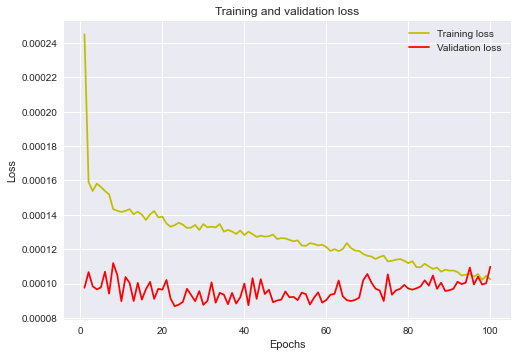

 37%|███▋      | 37/100 [28:26<46:06, 43.91s/it]

Epoch 1/100
119/119 [==============================] - 1s 6ms/step - loss: 2.3948e-04 - mean_absolute_error: 0.0111 - val_loss: 1.0191e-04 - val_mean_absolute_error: 0.0071
Epoch 2/100
119/119 [==============================] - 0s 4ms/step - loss: 1.6695e-04 - mean_absolute_error: 0.0093 - val_loss: 1.0538e-04 - val_mean_absolute_error: 0.0073
Epoch 3/100
119/119 [==============================] - 0s 4ms/step - loss: 1.6482e-04 - mean_absolute_error: 0.0092 - val_loss: 9.4004e-05 - val_mean_absolute_error: 0.0069
Epoch 4/100
119/119 [==============================] - 0s 4ms/step - loss: 1.5395e-04 - mean_absolute_error: 0.0089 - val_loss: 9.6103e-05 - val_mean_absolute_error: 0.0069
Epoch 5/100
119/119 [==============================] - 0s 4ms/step - loss: 1.5434e-04 - mean_absolute_error: 0.0089 - val_loss: 1.0443e-04 - val_mean_absolute_error: 0.0072
Epoch 6/100
119/119 [==============================] - 0s 4ms/step - loss: 1.4702e-04 - mean_absolute_error: 0.0087 - val_loss: 1.0561e

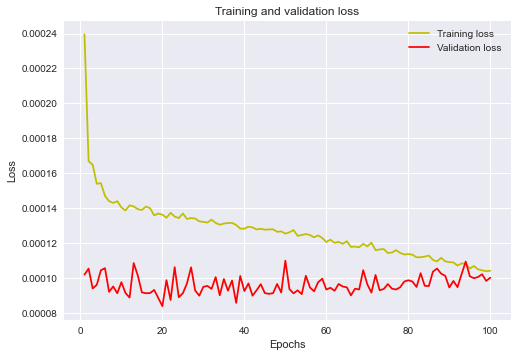

 38%|███▊      | 38/100 [29:10<45:22, 43.91s/it]

Epoch 1/100
119/119 [==============================] - 1s 6ms/step - loss: 2.0044e-04 - mean_absolute_error: 0.0101 - val_loss: 1.1387e-04 - val_mean_absolute_error: 0.0079
Epoch 2/100
119/119 [==============================] - 0s 4ms/step - loss: 1.5694e-04 - mean_absolute_error: 0.0090 - val_loss: 9.7012e-05 - val_mean_absolute_error: 0.0070
Epoch 3/100
119/119 [==============================] - 0s 4ms/step - loss: 1.5243e-04 - mean_absolute_error: 0.0090 - val_loss: 8.9888e-05 - val_mean_absolute_error: 0.0066
Epoch 4/100
119/119 [==============================] - 0s 3ms/step - loss: 1.5796e-04 - mean_absolute_error: 0.0091 - val_loss: 1.0940e-04 - val_mean_absolute_error: 0.0076
Epoch 5/100
119/119 [==============================] - 0s 4ms/step - loss: 1.4751e-04 - mean_absolute_error: 0.0088 - val_loss: 9.7767e-05 - val_mean_absolute_error: 0.0066
Epoch 6/100
119/119 [==============================] - 0s 4ms/step - loss: 1.5071e-04 - mean_absolute_error: 0.0090 - val_loss: 8.3056e

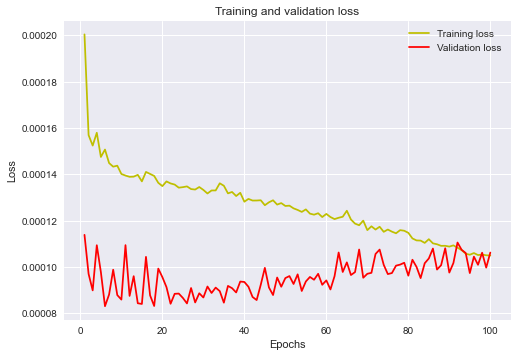

 39%|███▉      | 39/100 [29:53<44:31, 43.80s/it]

Epoch 1/100
119/119 [==============================] - 1s 6ms/step - loss: 2.0052e-04 - mean_absolute_error: 0.0104 - val_loss: 1.2470e-04 - val_mean_absolute_error: 0.0080
Epoch 2/100
119/119 [==============================] - 0s 4ms/step - loss: 1.6595e-04 - mean_absolute_error: 0.0093 - val_loss: 9.8392e-05 - val_mean_absolute_error: 0.0069
Epoch 3/100
119/119 [==============================] - 0s 4ms/step - loss: 1.6393e-04 - mean_absolute_error: 0.0093 - val_loss: 1.8725e-04 - val_mean_absolute_error: 0.0113
Epoch 4/100
119/119 [==============================] - 0s 3ms/step - loss: 1.5507e-04 - mean_absolute_error: 0.0091 - val_loss: 1.1314e-04 - val_mean_absolute_error: 0.0078
Epoch 5/100
119/119 [==============================] - 0s 3ms/step - loss: 1.5803e-04 - mean_absolute_error: 0.0092 - val_loss: 1.0557e-04 - val_mean_absolute_error: 0.0073
Epoch 6/100
119/119 [==============================] - 0s 3ms/step - loss: 1.5199e-04 - mean_absolute_error: 0.0089 - val_loss: 9.5303e

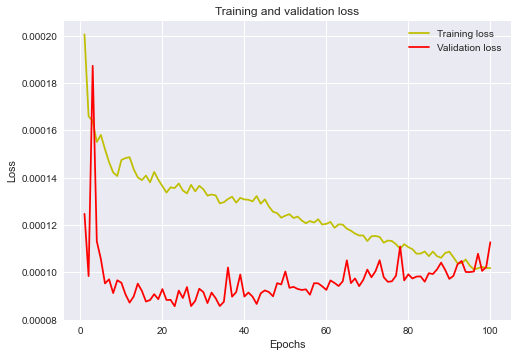

 40%|████      | 40/100 [30:36<43:37, 43.62s/it]

Epoch 1/100
119/119 [==============================] - 1s 5ms/step - loss: 2.4996e-04 - mean_absolute_error: 0.0111 - val_loss: 1.0071e-04 - val_mean_absolute_error: 0.0072
Epoch 2/100
119/119 [==============================] - 0s 4ms/step - loss: 1.5623e-04 - mean_absolute_error: 0.0090 - val_loss: 1.0265e-04 - val_mean_absolute_error: 0.0069
Epoch 3/100
119/119 [==============================] - 0s 4ms/step - loss: 1.5502e-04 - mean_absolute_error: 0.0090 - val_loss: 1.0201e-04 - val_mean_absolute_error: 0.0070
Epoch 4/100
119/119 [==============================] - 0s 3ms/step - loss: 1.5353e-04 - mean_absolute_error: 0.0090 - val_loss: 1.0338e-04 - val_mean_absolute_error: 0.0074
Epoch 5/100
119/119 [==============================] - 0s 3ms/step - loss: 1.4894e-04 - mean_absolute_error: 0.0089 - val_loss: 9.6050e-05 - val_mean_absolute_error: 0.0070
Epoch 6/100
119/119 [==============================] - 0s 3ms/step - loss: 1.4958e-04 - mean_absolute_error: 0.0089 - val_loss: 1.1709e

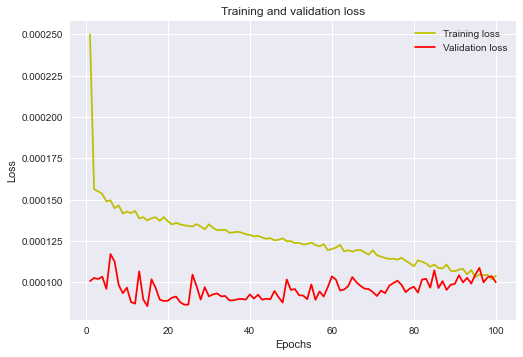

 41%|████      | 41/100 [31:20<42:50, 43.57s/it]

Epoch 1/100
119/119 [==============================] - 1s 5ms/step - loss: 2.1486e-04 - mean_absolute_error: 0.0105 - val_loss: 9.2301e-05 - val_mean_absolute_error: 0.0068
Epoch 2/100
119/119 [==============================] - 0s 4ms/step - loss: 1.6783e-04 - mean_absolute_error: 0.0094 - val_loss: 9.5710e-05 - val_mean_absolute_error: 0.0069
Epoch 3/100
119/119 [==============================] - 0s 3ms/step - loss: 1.6214e-04 - mean_absolute_error: 0.0092 - val_loss: 8.6796e-05 - val_mean_absolute_error: 0.0065
Epoch 4/100
119/119 [==============================] - 0s 4ms/step - loss: 1.5181e-04 - mean_absolute_error: 0.0089 - val_loss: 8.9320e-05 - val_mean_absolute_error: 0.0066
Epoch 5/100
119/119 [==============================] - 0s 3ms/step - loss: 1.4843e-04 - mean_absolute_error: 0.0089 - val_loss: 8.9726e-05 - val_mean_absolute_error: 0.0066
Epoch 6/100
119/119 [==============================] - 0s 4ms/step - loss: 1.4585e-04 - mean_absolute_error: 0.0087 - val_loss: 9.0382e

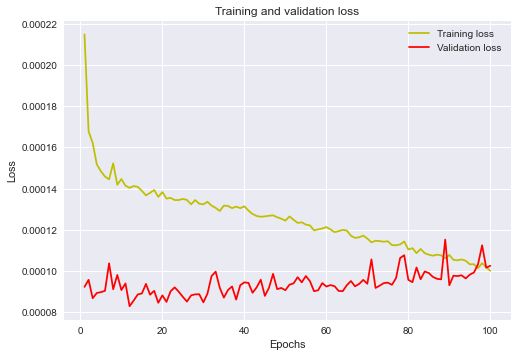

 42%|████▏     | 42/100 [32:04<42:13, 43.68s/it]

Epoch 1/100
119/119 [==============================] - 1s 5ms/step - loss: 1.9850e-04 - mean_absolute_error: 0.0103 - val_loss: 1.3977e-04 - val_mean_absolute_error: 0.0088
Epoch 2/100
119/119 [==============================] - 0s 4ms/step - loss: 1.6617e-04 - mean_absolute_error: 0.0093 - val_loss: 1.1312e-04 - val_mean_absolute_error: 0.0077
Epoch 3/100
119/119 [==============================] - 0s 4ms/step - loss: 1.7078e-04 - mean_absolute_error: 0.0095 - val_loss: 1.3404e-04 - val_mean_absolute_error: 0.0087
Epoch 4/100
119/119 [==============================] - 0s 3ms/step - loss: 1.4929e-04 - mean_absolute_error: 0.0089 - val_loss: 1.0758e-04 - val_mean_absolute_error: 0.0070
Epoch 5/100
119/119 [==============================] - 0s 4ms/step - loss: 1.4890e-04 - mean_absolute_error: 0.0089 - val_loss: 8.6754e-05 - val_mean_absolute_error: 0.0065
Epoch 6/100
119/119 [==============================] - 0s 4ms/step - loss: 1.4814e-04 - mean_absolute_error: 0.0088 - val_loss: 1.1043e

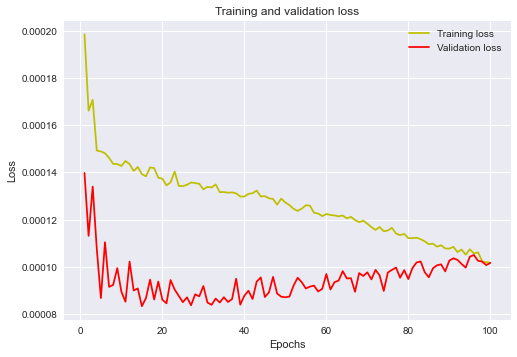

 43%|████▎     | 43/100 [32:52<42:43, 44.98s/it]

Epoch 1/100
119/119 [==============================] - 1s 6ms/step - loss: 2.6841e-04 - mean_absolute_error: 0.0116 - val_loss: 9.8264e-05 - val_mean_absolute_error: 0.0070
Epoch 2/100
119/119 [==============================] - 1s 4ms/step - loss: 1.6682e-04 - mean_absolute_error: 0.0095 - val_loss: 9.3848e-05 - val_mean_absolute_error: 0.0068
Epoch 3/100
119/119 [==============================] - 0s 4ms/step - loss: 1.6823e-04 - mean_absolute_error: 0.0094 - val_loss: 9.9879e-05 - val_mean_absolute_error: 0.0071
Epoch 4/100
119/119 [==============================] - 0s 4ms/step - loss: 1.5796e-04 - mean_absolute_error: 0.0091 - val_loss: 1.0366e-04 - val_mean_absolute_error: 0.0071
Epoch 5/100
119/119 [==============================] - 0s 4ms/step - loss: 1.5600e-04 - mean_absolute_error: 0.0090 - val_loss: 1.0173e-04 - val_mean_absolute_error: 0.0072
Epoch 6/100
119/119 [==============================] - 0s 4ms/step - loss: 1.5174e-04 - mean_absolute_error: 0.0091 - val_loss: 9.6008e

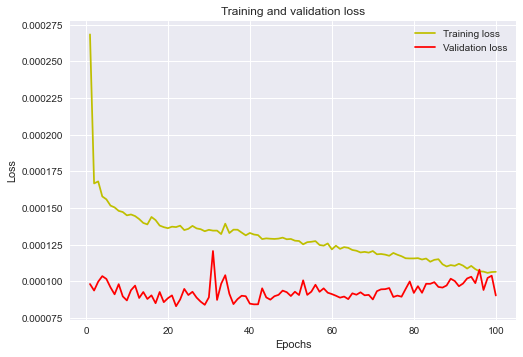

 44%|████▍     | 44/100 [33:36<41:52, 44.86s/it]

Epoch 1/100
119/119 [==============================] - 1s 5ms/step - loss: 2.2794e-04 - mean_absolute_error: 0.0106 - val_loss: 1.0733e-04 - val_mean_absolute_error: 0.0075
Epoch 2/100
119/119 [==============================] - 0s 4ms/step - loss: 1.5979e-04 - mean_absolute_error: 0.0092 - val_loss: 9.7863e-05 - val_mean_absolute_error: 0.0070
Epoch 3/100
119/119 [==============================] - 0s 4ms/step - loss: 1.5493e-04 - mean_absolute_error: 0.0091 - val_loss: 1.1463e-04 - val_mean_absolute_error: 0.0079
Epoch 4/100
119/119 [==============================] - 0s 3ms/step - loss: 1.5806e-04 - mean_absolute_error: 0.0091 - val_loss: 1.1048e-04 - val_mean_absolute_error: 0.0072
Epoch 5/100
119/119 [==============================] - 0s 3ms/step - loss: 1.5213e-04 - mean_absolute_error: 0.0090 - val_loss: 9.1868e-05 - val_mean_absolute_error: 0.0066
Epoch 6/100
119/119 [==============================] - 0s 4ms/step - loss: 1.4607e-04 - mean_absolute_error: 0.0088 - val_loss: 1.0200e

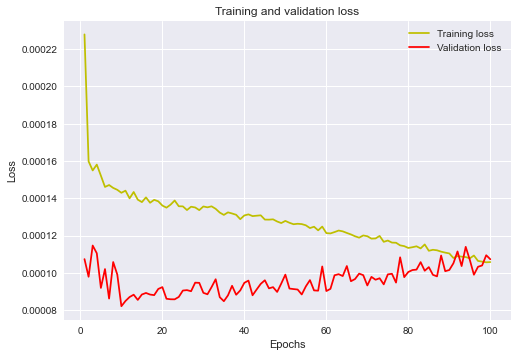

 45%|████▌     | 45/100 [34:19<40:38, 44.33s/it]

Epoch 1/100
119/119 [==============================] - 1s 5ms/step - loss: 2.4285e-04 - mean_absolute_error: 0.0111 - val_loss: 1.1456e-04 - val_mean_absolute_error: 0.0076
Epoch 2/100
119/119 [==============================] - 0s 4ms/step - loss: 1.6765e-04 - mean_absolute_error: 0.0094 - val_loss: 9.9139e-05 - val_mean_absolute_error: 0.0071
Epoch 3/100
119/119 [==============================] - 0s 4ms/step - loss: 1.6339e-04 - mean_absolute_error: 0.0093 - val_loss: 1.0020e-04 - val_mean_absolute_error: 0.0072
Epoch 4/100
119/119 [==============================] - 0s 3ms/step - loss: 1.5768e-04 - mean_absolute_error: 0.0091 - val_loss: 1.1023e-04 - val_mean_absolute_error: 0.0078
Epoch 5/100
119/119 [==============================] - 0s 3ms/step - loss: 1.5965e-04 - mean_absolute_error: 0.0092 - val_loss: 1.0337e-04 - val_mean_absolute_error: 0.0073
Epoch 6/100
119/119 [==============================] - 0s 3ms/step - loss: 1.5934e-04 - mean_absolute_error: 0.0091 - val_loss: 9.5114e

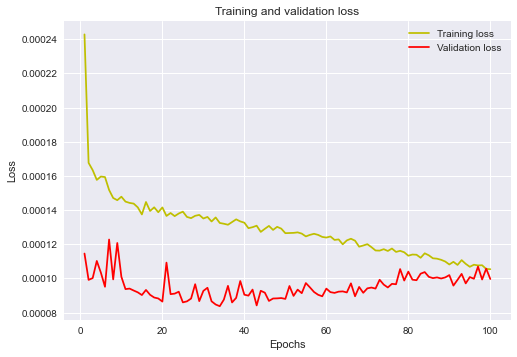

 46%|████▌     | 46/100 [35:03<39:47, 44.21s/it]

Epoch 1/100
119/119 [==============================] - 1s 5ms/step - loss: 2.1275e-04 - mean_absolute_error: 0.0104 - val_loss: 1.2771e-04 - val_mean_absolute_error: 0.0081
Epoch 2/100
119/119 [==============================] - 0s 4ms/step - loss: 1.6487e-04 - mean_absolute_error: 0.0094 - val_loss: 1.0010e-04 - val_mean_absolute_error: 0.0069
Epoch 3/100
119/119 [==============================] - 0s 4ms/step - loss: 1.5738e-04 - mean_absolute_error: 0.0091 - val_loss: 9.7705e-05 - val_mean_absolute_error: 0.0069
Epoch 4/100
119/119 [==============================] - 0s 4ms/step - loss: 1.5446e-04 - mean_absolute_error: 0.0090 - val_loss: 1.0272e-04 - val_mean_absolute_error: 0.0072
Epoch 5/100
119/119 [==============================] - 0s 3ms/step - loss: 1.5167e-04 - mean_absolute_error: 0.0089 - val_loss: 9.8418e-05 - val_mean_absolute_error: 0.0071
Epoch 6/100
119/119 [==============================] - 0s 4ms/step - loss: 1.4646e-04 - mean_absolute_error: 0.0088 - val_loss: 1.1316e

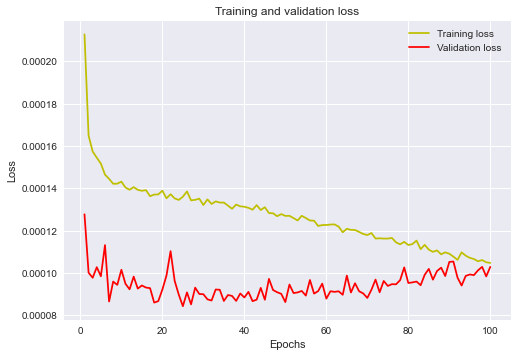

 47%|████▋     | 47/100 [35:47<38:59, 44.14s/it]

Epoch 1/100
119/119 [==============================] - 1s 6ms/step - loss: 1.9746e-04 - mean_absolute_error: 0.0102 - val_loss: 1.4005e-04 - val_mean_absolute_error: 0.0086
Epoch 2/100
119/119 [==============================] - 0s 4ms/step - loss: 1.6049e-04 - mean_absolute_error: 0.0093 - val_loss: 1.3521e-04 - val_mean_absolute_error: 0.0089
Epoch 3/100
119/119 [==============================] - 0s 3ms/step - loss: 1.5612e-04 - mean_absolute_error: 0.0091 - val_loss: 1.0727e-04 - val_mean_absolute_error: 0.0074
Epoch 4/100
119/119 [==============================] - 0s 3ms/step - loss: 1.5097e-04 - mean_absolute_error: 0.0089 - val_loss: 8.8682e-05 - val_mean_absolute_error: 0.0068
Epoch 5/100
119/119 [==============================] - 0s 4ms/step - loss: 1.5059e-04 - mean_absolute_error: 0.0089 - val_loss: 8.9868e-05 - val_mean_absolute_error: 0.0066
Epoch 6/100
119/119 [==============================] - 0s 3ms/step - loss: 1.4350e-04 - mean_absolute_error: 0.0087 - val_loss: 8.7415e

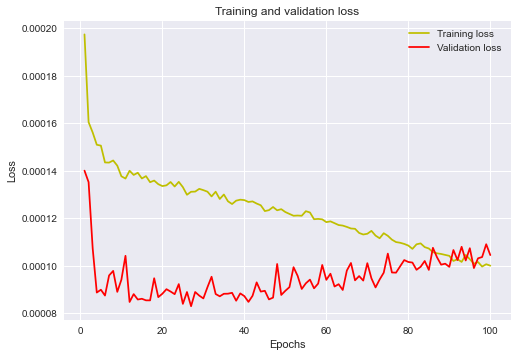

 48%|████▊     | 48/100 [36:30<37:55, 43.76s/it]

Epoch 1/100
119/119 [==============================] - 1s 5ms/step - loss: 2.6956e-04 - mean_absolute_error: 0.0113 - val_loss: 9.2668e-05 - val_mean_absolute_error: 0.0067
Epoch 2/100
119/119 [==============================] - 0s 4ms/step - loss: 1.6139e-04 - mean_absolute_error: 0.0093 - val_loss: 1.5473e-04 - val_mean_absolute_error: 0.0096
Epoch 3/100
119/119 [==============================] - 0s 4ms/step - loss: 1.5796e-04 - mean_absolute_error: 0.0092 - val_loss: 1.1733e-04 - val_mean_absolute_error: 0.0072
Epoch 4/100
119/119 [==============================] - 0s 3ms/step - loss: 1.5581e-04 - mean_absolute_error: 0.0090 - val_loss: 9.0456e-05 - val_mean_absolute_error: 0.0067
Epoch 5/100
119/119 [==============================] - 0s 3ms/step - loss: 1.5415e-04 - mean_absolute_error: 0.0090 - val_loss: 9.4748e-05 - val_mean_absolute_error: 0.0070
Epoch 6/100
119/119 [==============================] - 0s 4ms/step - loss: 1.4839e-04 - mean_absolute_error: 0.0089 - val_loss: 1.0842e

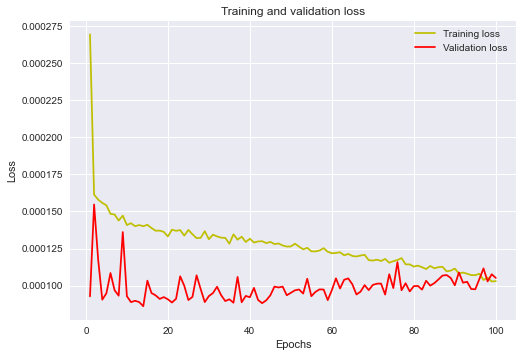

 49%|████▉     | 49/100 [37:12<36:40, 43.15s/it]

Epoch 1/100
119/119 [==============================] - 1s 5ms/step - loss: 2.1096e-04 - mean_absolute_error: 0.0107 - val_loss: 1.3462e-04 - val_mean_absolute_error: 0.0085
Epoch 2/100
119/119 [==============================] - 0s 3ms/step - loss: 1.5730e-04 - mean_absolute_error: 0.0092 - val_loss: 1.1453e-04 - val_mean_absolute_error: 0.0079
Epoch 3/100
119/119 [==============================] - 0s 3ms/step - loss: 1.5431e-04 - mean_absolute_error: 0.0090 - val_loss: 8.9213e-05 - val_mean_absolute_error: 0.0067
Epoch 4/100
119/119 [==============================] - 0s 3ms/step - loss: 1.5150e-04 - mean_absolute_error: 0.0090 - val_loss: 9.5601e-05 - val_mean_absolute_error: 0.0068
Epoch 5/100
119/119 [==============================] - 0s 3ms/step - loss: 1.4757e-04 - mean_absolute_error: 0.0088 - val_loss: 9.1703e-05 - val_mean_absolute_error: 0.0067
Epoch 6/100
119/119 [==============================] - 0s 3ms/step - loss: 1.4534e-04 - mean_absolute_error: 0.0088 - val_loss: 9.5373e

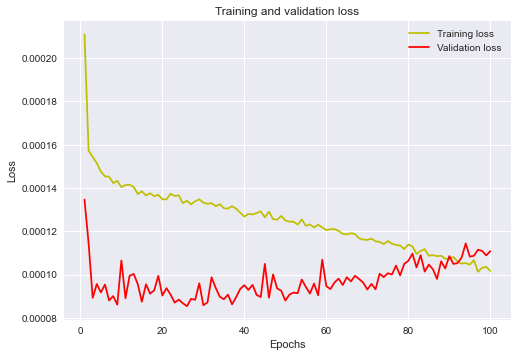

 50%|█████     | 50/100 [37:58<36:44, 44.08s/it]

Epoch 1/100
119/119 [==============================] - 1s 6ms/step - loss: 3.0235e-04 - mean_absolute_error: 0.0117 - val_loss: 1.1251e-04 - val_mean_absolute_error: 0.0073
Epoch 2/100
119/119 [==============================] - 0s 4ms/step - loss: 1.7087e-04 - mean_absolute_error: 0.0095 - val_loss: 1.2193e-04 - val_mean_absolute_error: 0.0075
Epoch 3/100
119/119 [==============================] - 0s 3ms/step - loss: 1.6582e-04 - mean_absolute_error: 0.0094 - val_loss: 1.0116e-04 - val_mean_absolute_error: 0.0071
Epoch 4/100
119/119 [==============================] - 0s 4ms/step - loss: 1.5710e-04 - mean_absolute_error: 0.0091 - val_loss: 9.5084e-05 - val_mean_absolute_error: 0.0068
Epoch 5/100
119/119 [==============================] - 0s 4ms/step - loss: 1.4873e-04 - mean_absolute_error: 0.0088 - val_loss: 9.6695e-05 - val_mean_absolute_error: 0.0070
Epoch 6/100
119/119 [==============================] - 0s 4ms/step - loss: 1.4623e-04 - mean_absolute_error: 0.0088 - val_loss: 1.1437e

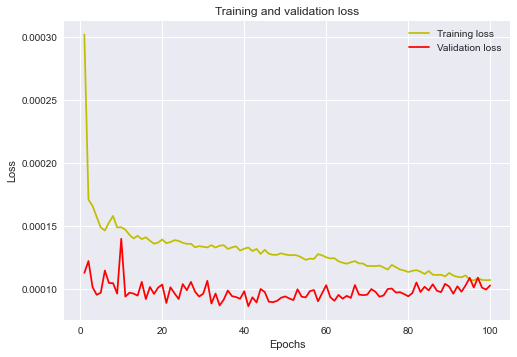

 51%|█████     | 51/100 [38:39<35:17, 43.21s/it]

Epoch 1/100
119/119 [==============================] - 1s 6ms/step - loss: 2.1620e-04 - mean_absolute_error: 0.0109 - val_loss: 2.2883e-04 - val_mean_absolute_error: 0.0118
Epoch 2/100
119/119 [==============================] - 0s 4ms/step - loss: 1.6497e-04 - mean_absolute_error: 0.0095 - val_loss: 1.1033e-04 - val_mean_absolute_error: 0.0071
Epoch 3/100
119/119 [==============================] - 0s 3ms/step - loss: 1.5727e-04 - mean_absolute_error: 0.0091 - val_loss: 9.6001e-05 - val_mean_absolute_error: 0.0068
Epoch 4/100
119/119 [==============================] - 0s 3ms/step - loss: 1.5457e-04 - mean_absolute_error: 0.0090 - val_loss: 8.7890e-05 - val_mean_absolute_error: 0.0066
Epoch 5/100
119/119 [==============================] - 0s 3ms/step - loss: 1.5211e-04 - mean_absolute_error: 0.0090 - val_loss: 9.2445e-05 - val_mean_absolute_error: 0.0065
Epoch 6/100
119/119 [==============================] - 0s 3ms/step - loss: 1.4871e-04 - mean_absolute_error: 0.0089 - val_loss: 9.7603e

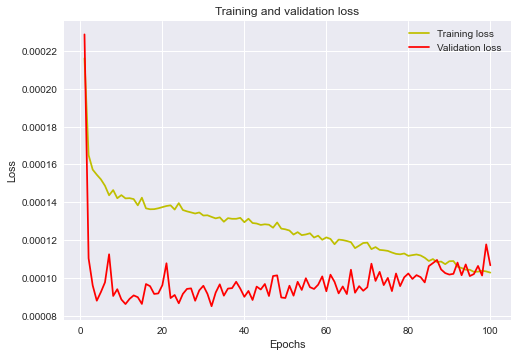

 52%|█████▏    | 52/100 [39:20<33:57, 42.46s/it]

Epoch 1/100
119/119 [==============================] - 1s 5ms/step - loss: 2.5081e-04 - mean_absolute_error: 0.0112 - val_loss: 1.1437e-04 - val_mean_absolute_error: 0.0079
Epoch 2/100
119/119 [==============================] - 0s 4ms/step - loss: 1.6085e-04 - mean_absolute_error: 0.0093 - val_loss: 1.0913e-04 - val_mean_absolute_error: 0.0076
Epoch 3/100
119/119 [==============================] - 0s 3ms/step - loss: 1.5877e-04 - mean_absolute_error: 0.0092 - val_loss: 1.2597e-04 - val_mean_absolute_error: 0.0083
Epoch 4/100
119/119 [==============================] - 0s 3ms/step - loss: 1.5754e-04 - mean_absolute_error: 0.0091 - val_loss: 1.0192e-04 - val_mean_absolute_error: 0.0074
Epoch 5/100
119/119 [==============================] - 0s 3ms/step - loss: 1.5551e-04 - mean_absolute_error: 0.0091 - val_loss: 9.4314e-05 - val_mean_absolute_error: 0.0068
Epoch 6/100
119/119 [==============================] - 0s 3ms/step - loss: 1.4740e-04 - mean_absolute_error: 0.0089 - val_loss: 1.0117e

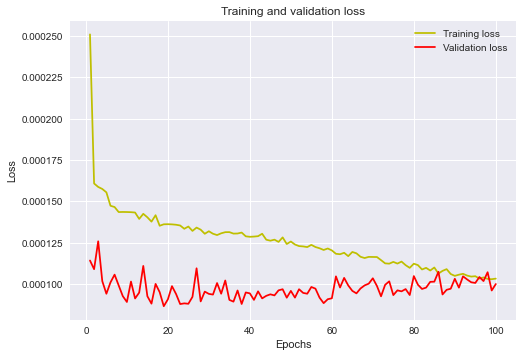

 53%|█████▎    | 53/100 [40:01<32:51, 41.94s/it]

Epoch 1/100
119/119 [==============================] - 1s 5ms/step - loss: 2.0666e-04 - mean_absolute_error: 0.0105 - val_loss: 9.3262e-05 - val_mean_absolute_error: 0.0068
Epoch 2/100
119/119 [==============================] - 0s 3ms/step - loss: 1.6942e-04 - mean_absolute_error: 0.0095 - val_loss: 1.2812e-04 - val_mean_absolute_error: 0.0086
Epoch 3/100
119/119 [==============================] - 0s 3ms/step - loss: 1.5424e-04 - mean_absolute_error: 0.0090 - val_loss: 1.0424e-04 - val_mean_absolute_error: 0.0071
Epoch 4/100
119/119 [==============================] - 0s 3ms/step - loss: 1.5907e-04 - mean_absolute_error: 0.0091 - val_loss: 1.0219e-04 - val_mean_absolute_error: 0.0072
Epoch 5/100
119/119 [==============================] - 0s 3ms/step - loss: 1.4874e-04 - mean_absolute_error: 0.0088 - val_loss: 9.3279e-05 - val_mean_absolute_error: 0.0068
Epoch 6/100
119/119 [==============================] - 0s 3ms/step - loss: 1.5119e-04 - mean_absolute_error: 0.0089 - val_loss: 1.1296e

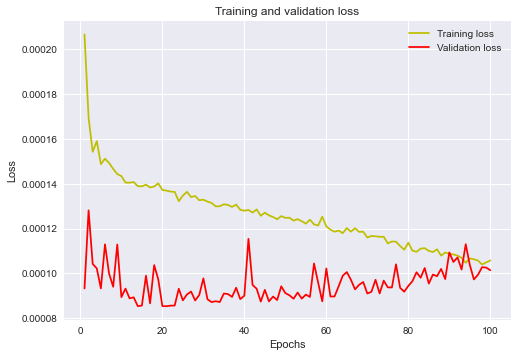

 54%|█████▍    | 54/100 [40:41<31:48, 41.49s/it]

Epoch 1/100
119/119 [==============================] - 1s 5ms/step - loss: 2.5052e-04 - mean_absolute_error: 0.0110 - val_loss: 9.5374e-05 - val_mean_absolute_error: 0.0071
Epoch 2/100
119/119 [==============================] - 0s 4ms/step - loss: 1.6572e-04 - mean_absolute_error: 0.0095 - val_loss: 1.3463e-04 - val_mean_absolute_error: 0.0088
Epoch 3/100
119/119 [==============================] - 0s 3ms/step - loss: 1.6354e-04 - mean_absolute_error: 0.0094 - val_loss: 1.2433e-04 - val_mean_absolute_error: 0.0086
Epoch 4/100
119/119 [==============================] - 0s 3ms/step - loss: 1.5743e-04 - mean_absolute_error: 0.0092 - val_loss: 1.3487e-04 - val_mean_absolute_error: 0.0083
Epoch 5/100
119/119 [==============================] - 0s 3ms/step - loss: 1.6324e-04 - mean_absolute_error: 0.0094 - val_loss: 1.2542e-04 - val_mean_absolute_error: 0.0086
Epoch 6/100
119/119 [==============================] - 0s 3ms/step - loss: 1.5078e-04 - mean_absolute_error: 0.0089 - val_loss: 9.7549e

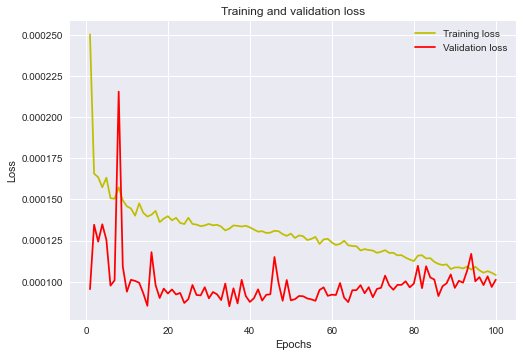

 55%|█████▌    | 55/100 [41:22<30:57, 41.27s/it]

Epoch 1/100
119/119 [==============================] - 1s 5ms/step - loss: 2.3849e-04 - mean_absolute_error: 0.0109 - val_loss: 9.7698e-05 - val_mean_absolute_error: 0.0070
Epoch 2/100
119/119 [==============================] - 0s 3ms/step - loss: 1.5872e-04 - mean_absolute_error: 0.0093 - val_loss: 1.7799e-04 - val_mean_absolute_error: 0.0099
Epoch 3/100
119/119 [==============================] - 0s 4ms/step - loss: 1.6030e-04 - mean_absolute_error: 0.0093 - val_loss: 1.0622e-04 - val_mean_absolute_error: 0.0072
Epoch 4/100
119/119 [==============================] - 0s 3ms/step - loss: 1.5761e-04 - mean_absolute_error: 0.0092 - val_loss: 9.4247e-05 - val_mean_absolute_error: 0.0068
Epoch 5/100
119/119 [==============================] - 0s 3ms/step - loss: 1.5133e-04 - mean_absolute_error: 0.0090 - val_loss: 9.4926e-05 - val_mean_absolute_error: 0.0070
Epoch 6/100
119/119 [==============================] - 0s 3ms/step - loss: 1.4924e-04 - mean_absolute_error: 0.0089 - val_loss: 1.2333e

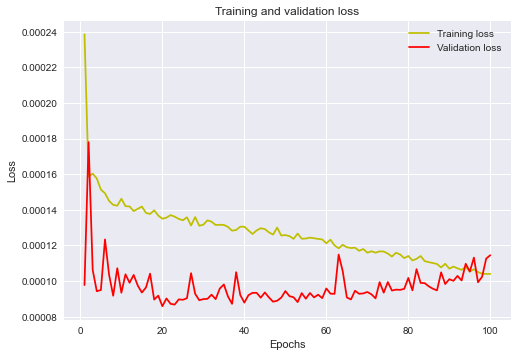

 56%|█████▌    | 56/100 [42:02<30:03, 40.99s/it]

Epoch 1/100
119/119 [==============================] - 1s 6ms/step - loss: 2.1215e-04 - mean_absolute_error: 0.0106 - val_loss: 1.0786e-04 - val_mean_absolute_error: 0.0076
Epoch 2/100
119/119 [==============================] - 0s 4ms/step - loss: 1.6588e-04 - mean_absolute_error: 0.0094 - val_loss: 1.1977e-04 - val_mean_absolute_error: 0.0076
Epoch 3/100
119/119 [==============================] - 0s 3ms/step - loss: 1.5624e-04 - mean_absolute_error: 0.0091 - val_loss: 1.1703e-04 - val_mean_absolute_error: 0.0077
Epoch 4/100
119/119 [==============================] - 0s 3ms/step - loss: 1.5302e-04 - mean_absolute_error: 0.0089 - val_loss: 8.9789e-05 - val_mean_absolute_error: 0.0067
Epoch 5/100
119/119 [==============================] - 0s 3ms/step - loss: 1.4810e-04 - mean_absolute_error: 0.0088 - val_loss: 1.0167e-04 - val_mean_absolute_error: 0.0073
Epoch 6/100
119/119 [==============================] - 0s 3ms/step - loss: 1.4635e-04 - mean_absolute_error: 0.0088 - val_loss: 8.5513e

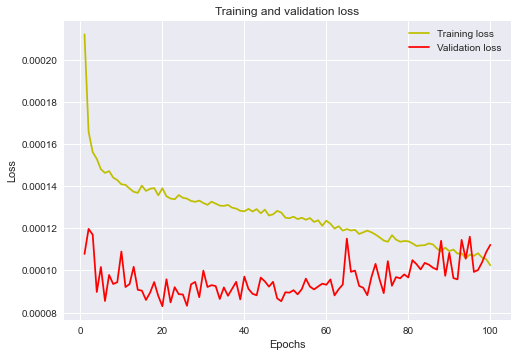

 57%|█████▋    | 57/100 [42:43<29:23, 41.00s/it]

Epoch 1/100
119/119 [==============================] - 1s 6ms/step - loss: 3.1221e-04 - mean_absolute_error: 0.0120 - val_loss: 1.2208e-04 - val_mean_absolute_error: 0.0084
Epoch 2/100
119/119 [==============================] - 0s 4ms/step - loss: 1.5524e-04 - mean_absolute_error: 0.0091 - val_loss: 1.0318e-04 - val_mean_absolute_error: 0.0073
Epoch 3/100
119/119 [==============================] - 0s 3ms/step - loss: 1.5891e-04 - mean_absolute_error: 0.0092 - val_loss: 9.8235e-05 - val_mean_absolute_error: 0.0071
Epoch 4/100
119/119 [==============================] - 0s 3ms/step - loss: 1.5518e-04 - mean_absolute_error: 0.0090 - val_loss: 9.2276e-05 - val_mean_absolute_error: 0.0068
Epoch 5/100
119/119 [==============================] - 0s 3ms/step - loss: 1.4760e-04 - mean_absolute_error: 0.0089 - val_loss: 9.3138e-05 - val_mean_absolute_error: 0.0068
Epoch 6/100
119/119 [==============================] - 0s 3ms/step - loss: 1.4720e-04 - mean_absolute_error: 0.0089 - val_loss: 8.5729e

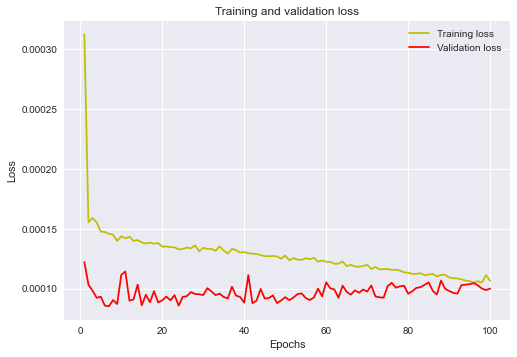

 58%|█████▊    | 58/100 [43:24<28:39, 40.94s/it]

Epoch 1/100
119/119 [==============================] - 1s 5ms/step - loss: 2.3793e-04 - mean_absolute_error: 0.0106 - val_loss: 1.0033e-04 - val_mean_absolute_error: 0.0068
Epoch 2/100
119/119 [==============================] - 0s 3ms/step - loss: 1.6115e-04 - mean_absolute_error: 0.0091 - val_loss: 9.4022e-05 - val_mean_absolute_error: 0.0069
Epoch 3/100
119/119 [==============================] - 0s 3ms/step - loss: 1.5579e-04 - mean_absolute_error: 0.0091 - val_loss: 1.0880e-04 - val_mean_absolute_error: 0.0077
Epoch 4/100
119/119 [==============================] - 0s 3ms/step - loss: 1.4792e-04 - mean_absolute_error: 0.0088 - val_loss: 9.5097e-05 - val_mean_absolute_error: 0.0069
Epoch 5/100
119/119 [==============================] - 0s 3ms/step - loss: 1.5084e-04 - mean_absolute_error: 0.0089 - val_loss: 8.7773e-05 - val_mean_absolute_error: 0.0066
Epoch 6/100
119/119 [==============================] - 0s 4ms/step - loss: 1.4449e-04 - mean_absolute_error: 0.0086 - val_loss: 8.8064e

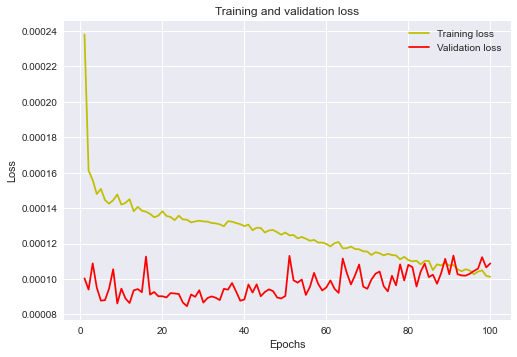

 59%|█████▉    | 59/100 [44:06<28:13, 41.30s/it]

Epoch 1/100
119/119 [==============================] - 1s 5ms/step - loss: 2.6817e-04 - mean_absolute_error: 0.0114 - val_loss: 1.0717e-04 - val_mean_absolute_error: 0.0072
Epoch 2/100
119/119 [==============================] - 0s 3ms/step - loss: 1.7200e-04 - mean_absolute_error: 0.0096 - val_loss: 9.8853e-05 - val_mean_absolute_error: 0.0069
Epoch 3/100
119/119 [==============================] - 0s 3ms/step - loss: 1.6478e-04 - mean_absolute_error: 0.0093 - val_loss: 1.1879e-04 - val_mean_absolute_error: 0.0078
Epoch 4/100
119/119 [==============================] - 0s 3ms/step - loss: 1.5451e-04 - mean_absolute_error: 0.0091 - val_loss: 1.2042e-04 - val_mean_absolute_error: 0.0082
Epoch 5/100
119/119 [==============================] - 0s 3ms/step - loss: 1.5368e-04 - mean_absolute_error: 0.0090 - val_loss: 9.7692e-05 - val_mean_absolute_error: 0.0072
Epoch 6/100
119/119 [==============================] - 0s 3ms/step - loss: 1.4994e-04 - mean_absolute_error: 0.0089 - val_loss: 9.3459e

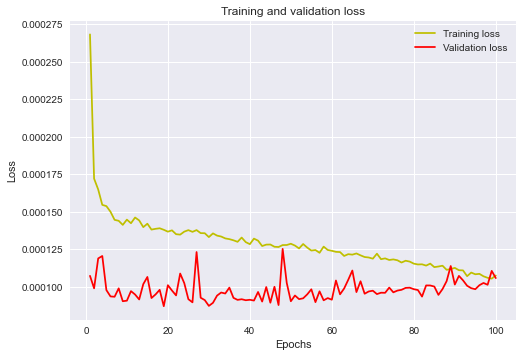

 60%|██████    | 60/100 [44:47<27:29, 41.23s/it]

Epoch 1/100
119/119 [==============================] - 1s 5ms/step - loss: 2.3918e-04 - mean_absolute_error: 0.0109 - val_loss: 9.7170e-05 - val_mean_absolute_error: 0.0069
Epoch 2/100
119/119 [==============================] - 0s 4ms/step - loss: 1.6361e-04 - mean_absolute_error: 0.0094 - val_loss: 9.6349e-05 - val_mean_absolute_error: 0.0069
Epoch 3/100
119/119 [==============================] - 0s 3ms/step - loss: 1.6785e-04 - mean_absolute_error: 0.0095 - val_loss: 1.0431e-04 - val_mean_absolute_error: 0.0072
Epoch 4/100
119/119 [==============================] - 0s 3ms/step - loss: 1.5083e-04 - mean_absolute_error: 0.0089 - val_loss: 1.0517e-04 - val_mean_absolute_error: 0.0073
Epoch 5/100
119/119 [==============================] - 0s 3ms/step - loss: 1.5149e-04 - mean_absolute_error: 0.0090 - val_loss: 1.0034e-04 - val_mean_absolute_error: 0.0071
Epoch 6/100
119/119 [==============================] - 0s 3ms/step - loss: 1.4867e-04 - mean_absolute_error: 0.0088 - val_loss: 9.0514e

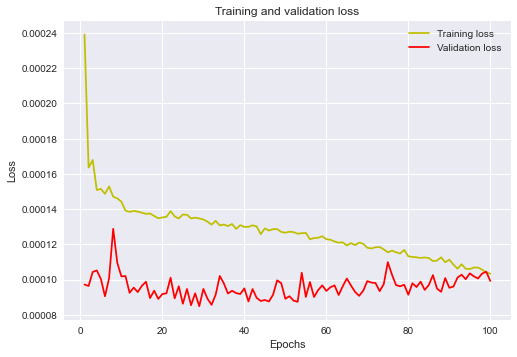

 61%|██████    | 61/100 [45:28<26:42, 41.09s/it]

Epoch 1/100
119/119 [==============================] - 1s 5ms/step - loss: 2.1390e-04 - mean_absolute_error: 0.0106 - val_loss: 1.0295e-04 - val_mean_absolute_error: 0.0075
Epoch 2/100
119/119 [==============================] - 0s 4ms/step - loss: 1.6449e-04 - mean_absolute_error: 0.0093 - val_loss: 1.1649e-04 - val_mean_absolute_error: 0.0082
Epoch 3/100
119/119 [==============================] - 0s 4ms/step - loss: 1.5969e-04 - mean_absolute_error: 0.0091 - val_loss: 1.1485e-04 - val_mean_absolute_error: 0.0075
Epoch 4/100
119/119 [==============================] - 0s 3ms/step - loss: 1.5489e-04 - mean_absolute_error: 0.0090 - val_loss: 9.8172e-05 - val_mean_absolute_error: 0.0071
Epoch 5/100
119/119 [==============================] - 0s 4ms/step - loss: 1.5162e-04 - mean_absolute_error: 0.0090 - val_loss: 8.8309e-05 - val_mean_absolute_error: 0.0065
Epoch 6/100
119/119 [==============================] - 0s 4ms/step - loss: 1.4487e-04 - mean_absolute_error: 0.0088 - val_loss: 8.6292e

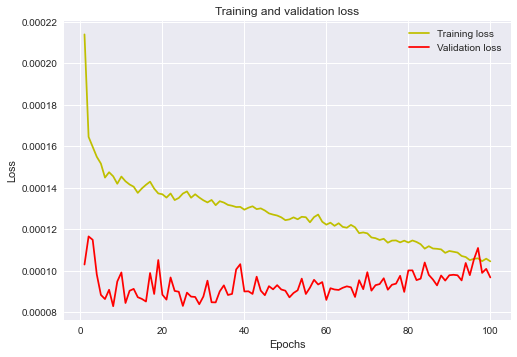

 62%|██████▏   | 62/100 [46:09<26:01, 41.09s/it]

Epoch 1/100
119/119 [==============================] - 1s 5ms/step - loss: 4.4342e-04 - mean_absolute_error: 0.0126 - val_loss: 9.1137e-05 - val_mean_absolute_error: 0.0067
Epoch 2/100
119/119 [==============================] - 0s 3ms/step - loss: 1.5269e-04 - mean_absolute_error: 0.0089 - val_loss: 9.0277e-05 - val_mean_absolute_error: 0.0068
Epoch 3/100
119/119 [==============================] - 0s 3ms/step - loss: 1.4846e-04 - mean_absolute_error: 0.0088 - val_loss: 9.3594e-05 - val_mean_absolute_error: 0.0067
Epoch 4/100
119/119 [==============================] - 0s 3ms/step - loss: 1.5425e-04 - mean_absolute_error: 0.0089 - val_loss: 1.3158e-04 - val_mean_absolute_error: 0.0087
Epoch 5/100
119/119 [==============================] - 0s 3ms/step - loss: 1.4766e-04 - mean_absolute_error: 0.0089 - val_loss: 9.1269e-05 - val_mean_absolute_error: 0.0066
Epoch 6/100
119/119 [==============================] - 0s 3ms/step - loss: 1.4686e-04 - mean_absolute_error: 0.0088 - val_loss: 8.7313e

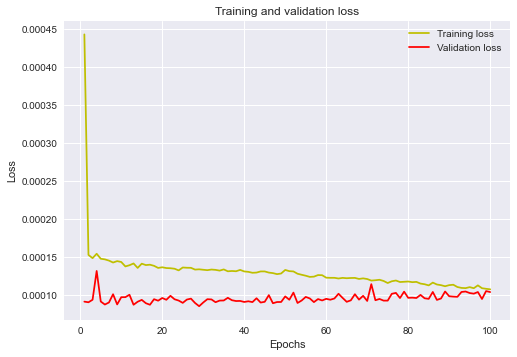

 63%|██████▎   | 63/100 [46:50<25:19, 41.08s/it]

Epoch 1/100
119/119 [==============================] - 1s 5ms/step - loss: 2.9578e-04 - mean_absolute_error: 0.0113 - val_loss: 9.3063e-05 - val_mean_absolute_error: 0.0069
Epoch 2/100
119/119 [==============================] - 0s 4ms/step - loss: 1.5595e-04 - mean_absolute_error: 0.0091 - val_loss: 9.4830e-05 - val_mean_absolute_error: 0.0069
Epoch 3/100
119/119 [==============================] - 0s 3ms/step - loss: 1.5536e-04 - mean_absolute_error: 0.0090 - val_loss: 8.9813e-05 - val_mean_absolute_error: 0.0066
Epoch 4/100
119/119 [==============================] - 0s 3ms/step - loss: 1.5282e-04 - mean_absolute_error: 0.0089 - val_loss: 1.0438e-04 - val_mean_absolute_error: 0.0071
Epoch 5/100
119/119 [==============================] - 0s 3ms/step - loss: 1.5086e-04 - mean_absolute_error: 0.0090 - val_loss: 1.1058e-04 - val_mean_absolute_error: 0.0078
Epoch 6/100
119/119 [==============================] - 0s 3ms/step - loss: 1.4415e-04 - mean_absolute_error: 0.0087 - val_loss: 1.1191e

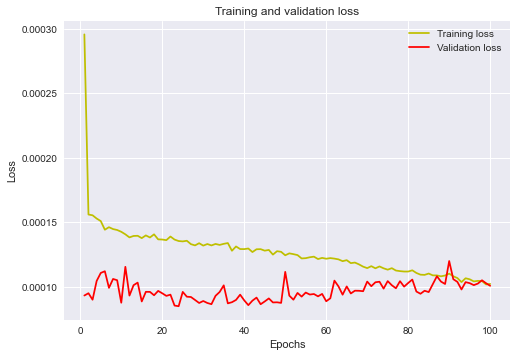

 64%|██████▍   | 64/100 [47:31<24:39, 41.08s/it]

Epoch 1/100
119/119 [==============================] - 1s 5ms/step - loss: 2.2068e-04 - mean_absolute_error: 0.0109 - val_loss: 1.1723e-04 - val_mean_absolute_error: 0.0080
Epoch 2/100
119/119 [==============================] - 0s 4ms/step - loss: 1.6880e-04 - mean_absolute_error: 0.0094 - val_loss: 1.0164e-04 - val_mean_absolute_error: 0.0072
Epoch 3/100
119/119 [==============================] - 0s 3ms/step - loss: 1.6895e-04 - mean_absolute_error: 0.0095 - val_loss: 1.0773e-04 - val_mean_absolute_error: 0.0072
Epoch 4/100
119/119 [==============================] - 0s 3ms/step - loss: 1.5857e-04 - mean_absolute_error: 0.0092 - val_loss: 9.2779e-05 - val_mean_absolute_error: 0.0068
Epoch 5/100
119/119 [==============================] - 0s 3ms/step - loss: 1.5887e-04 - mean_absolute_error: 0.0091 - val_loss: 9.1007e-05 - val_mean_absolute_error: 0.0067
Epoch 6/100
119/119 [==============================] - 0s 3ms/step - loss: 1.4940e-04 - mean_absolute_error: 0.0089 - val_loss: 1.0962e

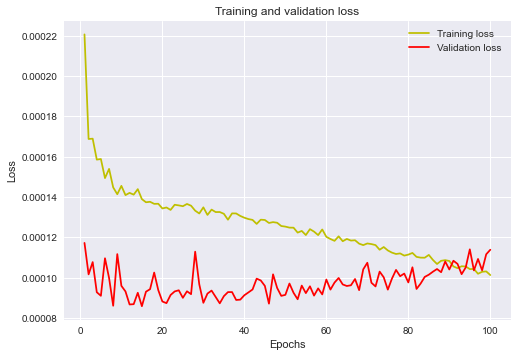

 65%|██████▌   | 65/100 [48:12<23:56, 41.05s/it]

Epoch 1/100
119/119 [==============================] - 1s 5ms/step - loss: 1.8615e-04 - mean_absolute_error: 0.0099 - val_loss: 1.0804e-04 - val_mean_absolute_error: 0.0075
Epoch 2/100
119/119 [==============================] - 0s 3ms/step - loss: 1.5742e-04 - mean_absolute_error: 0.0091 - val_loss: 1.1173e-04 - val_mean_absolute_error: 0.0076
Epoch 3/100
119/119 [==============================] - 0s 4ms/step - loss: 1.5507e-04 - mean_absolute_error: 0.0091 - val_loss: 1.2278e-04 - val_mean_absolute_error: 0.0073
Epoch 4/100
119/119 [==============================] - 0s 3ms/step - loss: 1.6058e-04 - mean_absolute_error: 0.0092 - val_loss: 1.0201e-04 - val_mean_absolute_error: 0.0072
Epoch 5/100
119/119 [==============================] - 0s 3ms/step - loss: 1.5227e-04 - mean_absolute_error: 0.0089 - val_loss: 9.5171e-05 - val_mean_absolute_error: 0.0069
Epoch 6/100
119/119 [==============================] - 0s 3ms/step - loss: 1.4747e-04 - mean_absolute_error: 0.0088 - val_loss: 1.2143e

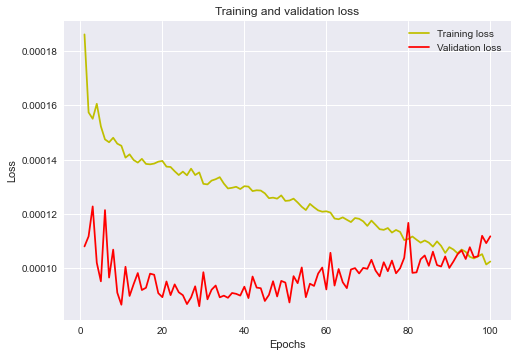

 66%|██████▌   | 66/100 [48:54<23:19, 41.18s/it]

Epoch 1/100
119/119 [==============================] - 1s 5ms/step - loss: 2.7923e-04 - mean_absolute_error: 0.0112 - val_loss: 9.5781e-05 - val_mean_absolute_error: 0.0069
Epoch 2/100
119/119 [==============================] - 0s 4ms/step - loss: 1.6525e-04 - mean_absolute_error: 0.0094 - val_loss: 1.1027e-04 - val_mean_absolute_error: 0.0069
Epoch 3/100
119/119 [==============================] - 0s 3ms/step - loss: 1.5965e-04 - mean_absolute_error: 0.0091 - val_loss: 1.0260e-04 - val_mean_absolute_error: 0.0072
Epoch 4/100
119/119 [==============================] - 0s 3ms/step - loss: 1.5396e-04 - mean_absolute_error: 0.0089 - val_loss: 1.2254e-04 - val_mean_absolute_error: 0.0081
Epoch 5/100
119/119 [==============================] - 0s 3ms/step - loss: 1.5224e-04 - mean_absolute_error: 0.0090 - val_loss: 9.7251e-05 - val_mean_absolute_error: 0.0071
Epoch 6/100
119/119 [==============================] - 0s 3ms/step - loss: 1.4801e-04 - mean_absolute_error: 0.0088 - val_loss: 9.6153e

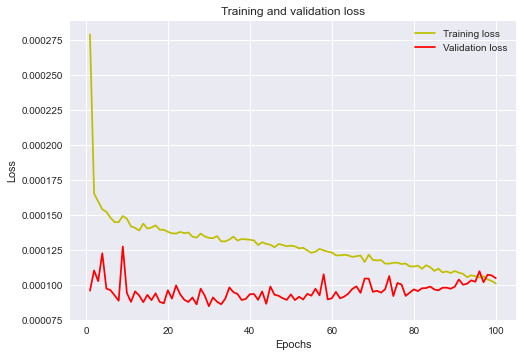

 67%|██████▋   | 67/100 [49:36<22:44, 41.36s/it]

Epoch 1/100
119/119 [==============================] - 1s 5ms/step - loss: 2.2576e-04 - mean_absolute_error: 0.0106 - val_loss: 1.0358e-04 - val_mean_absolute_error: 0.0073
Epoch 2/100
119/119 [==============================] - 0s 4ms/step - loss: 1.5467e-04 - mean_absolute_error: 0.0090 - val_loss: 1.2113e-04 - val_mean_absolute_error: 0.0081
Epoch 3/100
119/119 [==============================] - 0s 3ms/step - loss: 1.5852e-04 - mean_absolute_error: 0.0092 - val_loss: 9.5077e-05 - val_mean_absolute_error: 0.0069
Epoch 4/100
119/119 [==============================] - 0s 3ms/step - loss: 1.5475e-04 - mean_absolute_error: 0.0090 - val_loss: 1.1899e-04 - val_mean_absolute_error: 0.0081
Epoch 5/100
119/119 [==============================] - 0s 3ms/step - loss: 1.4851e-04 - mean_absolute_error: 0.0089 - val_loss: 8.9748e-05 - val_mean_absolute_error: 0.0066
Epoch 6/100
119/119 [==============================] - 0s 3ms/step - loss: 1.5063e-04 - mean_absolute_error: 0.0089 - val_loss: 1.1834e

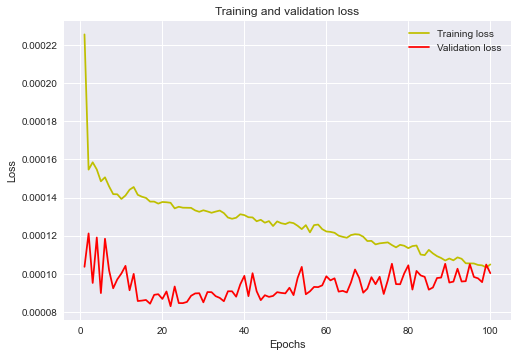

 68%|██████▊   | 68/100 [50:16<21:58, 41.20s/it]

Epoch 1/100
119/119 [==============================] - 1s 5ms/step - loss: 1.9699e-04 - mean_absolute_error: 0.0103 - val_loss: 9.6513e-05 - val_mean_absolute_error: 0.0069
Epoch 2/100
119/119 [==============================] - 0s 4ms/step - loss: 1.6614e-04 - mean_absolute_error: 0.0093 - val_loss: 1.1767e-04 - val_mean_absolute_error: 0.0078
Epoch 3/100
119/119 [==============================] - 0s 3ms/step - loss: 1.5665e-04 - mean_absolute_error: 0.0091 - val_loss: 9.2907e-05 - val_mean_absolute_error: 0.0069
Epoch 4/100
119/119 [==============================] - 0s 3ms/step - loss: 1.5801e-04 - mean_absolute_error: 0.0091 - val_loss: 1.1510e-04 - val_mean_absolute_error: 0.0078
Epoch 5/100
119/119 [==============================] - 0s 3ms/step - loss: 1.5179e-04 - mean_absolute_error: 0.0089 - val_loss: 1.0154e-04 - val_mean_absolute_error: 0.0072
Epoch 6/100
119/119 [==============================] - 0s 3ms/step - loss: 1.4268e-04 - mean_absolute_error: 0.0087 - val_loss: 1.1343e

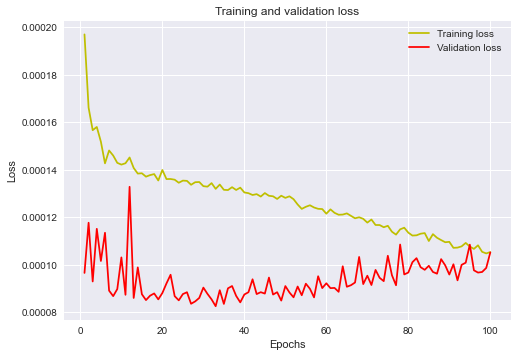

 69%|██████▉   | 69/100 [50:57<21:13, 41.07s/it]

Epoch 1/100
119/119 [==============================] - 1s 5ms/step - loss: 2.5858e-04 - mean_absolute_error: 0.0110 - val_loss: 1.2573e-04 - val_mean_absolute_error: 0.0081
Epoch 2/100
119/119 [==============================] - 0s 4ms/step - loss: 1.5717e-04 - mean_absolute_error: 0.0092 - val_loss: 9.7507e-05 - val_mean_absolute_error: 0.0071
Epoch 3/100
119/119 [==============================] - 0s 4ms/step - loss: 1.5614e-04 - mean_absolute_error: 0.0091 - val_loss: 9.5183e-05 - val_mean_absolute_error: 0.0070
Epoch 4/100
119/119 [==============================] - 0s 3ms/step - loss: 1.5020e-04 - mean_absolute_error: 0.0089 - val_loss: 9.9048e-05 - val_mean_absolute_error: 0.0070
Epoch 5/100
119/119 [==============================] - 0s 3ms/step - loss: 1.5010e-04 - mean_absolute_error: 0.0089 - val_loss: 1.0522e-04 - val_mean_absolute_error: 0.0075
Epoch 6/100
119/119 [==============================] - 0s 3ms/step - loss: 1.4772e-04 - mean_absolute_error: 0.0088 - val_loss: 9.1924e

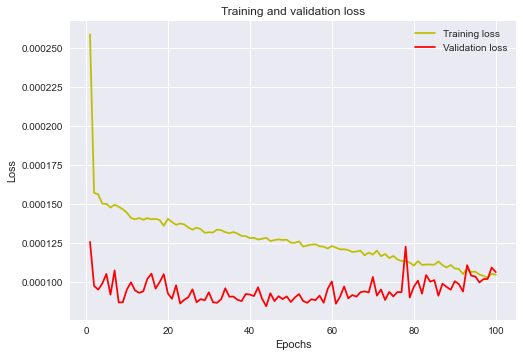

 70%|███████   | 70/100 [51:38<20:31, 41.06s/it]

Epoch 1/100
119/119 [==============================] - 1s 6ms/step - loss: 1.9688e-04 - mean_absolute_error: 0.0103 - val_loss: 1.5402e-04 - val_mean_absolute_error: 0.0096
Epoch 2/100
119/119 [==============================] - 0s 4ms/step - loss: 1.7930e-04 - mean_absolute_error: 0.0097 - val_loss: 1.3267e-04 - val_mean_absolute_error: 0.0084
Epoch 3/100
119/119 [==============================] - 0s 4ms/step - loss: 1.5720e-04 - mean_absolute_error: 0.0091 - val_loss: 1.0465e-04 - val_mean_absolute_error: 0.0074
Epoch 4/100
119/119 [==============================] - 0s 4ms/step - loss: 1.4887e-04 - mean_absolute_error: 0.0090 - val_loss: 1.0873e-04 - val_mean_absolute_error: 0.0073
Epoch 5/100
119/119 [==============================] - 0s 4ms/step - loss: 1.5414e-04 - mean_absolute_error: 0.0090 - val_loss: 1.3174e-04 - val_mean_absolute_error: 0.0085
Epoch 6/100
119/119 [==============================] - 0s 4ms/step - loss: 1.4904e-04 - mean_absolute_error: 0.0088 - val_loss: 9.3177e

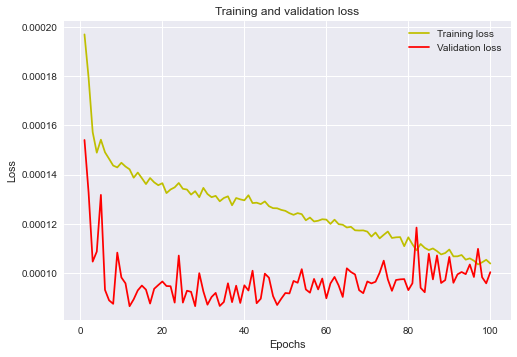

 71%|███████   | 71/100 [52:21<20:08, 41.66s/it]

Epoch 1/100
119/119 [==============================] - 1s 5ms/step - loss: 2.0132e-04 - mean_absolute_error: 0.0103 - val_loss: 1.1414e-04 - val_mean_absolute_error: 0.0078
Epoch 2/100
119/119 [==============================] - 0s 4ms/step - loss: 1.5893e-04 - mean_absolute_error: 0.0092 - val_loss: 9.1451e-05 - val_mean_absolute_error: 0.0066
Epoch 3/100
119/119 [==============================] - 0s 3ms/step - loss: 1.5426e-04 - mean_absolute_error: 0.0090 - val_loss: 9.3274e-05 - val_mean_absolute_error: 0.0068
Epoch 4/100
119/119 [==============================] - 0s 3ms/step - loss: 1.5103e-04 - mean_absolute_error: 0.0088 - val_loss: 8.9678e-05 - val_mean_absolute_error: 0.0065
Epoch 5/100
119/119 [==============================] - 0s 3ms/step - loss: 1.4931e-04 - mean_absolute_error: 0.0089 - val_loss: 8.8247e-05 - val_mean_absolute_error: 0.0066
Epoch 6/100
119/119 [==============================] - 0s 3ms/step - loss: 1.4688e-04 - mean_absolute_error: 0.0088 - val_loss: 9.9543e

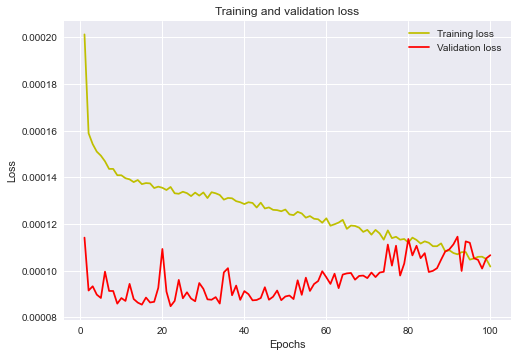

 72%|███████▏  | 72/100 [53:04<19:32, 41.86s/it]

Epoch 1/100
119/119 [==============================] - 1s 5ms/step - loss: 2.5567e-04 - mean_absolute_error: 0.0111 - val_loss: 1.1122e-04 - val_mean_absolute_error: 0.0076
Epoch 2/100
119/119 [==============================] - 0s 4ms/step - loss: 1.6470e-04 - mean_absolute_error: 0.0093 - val_loss: 1.3123e-04 - val_mean_absolute_error: 0.0079
Epoch 3/100
119/119 [==============================] - 0s 3ms/step - loss: 1.5789e-04 - mean_absolute_error: 0.0092 - val_loss: 1.0823e-04 - val_mean_absolute_error: 0.0071
Epoch 4/100
119/119 [==============================] - 0s 3ms/step - loss: 1.5448e-04 - mean_absolute_error: 0.0091 - val_loss: 9.5450e-05 - val_mean_absolute_error: 0.0069
Epoch 5/100
119/119 [==============================] - 0s 4ms/step - loss: 1.5210e-04 - mean_absolute_error: 0.0090 - val_loss: 8.8105e-05 - val_mean_absolute_error: 0.0064
Epoch 6/100
119/119 [==============================] - 0s 3ms/step - loss: 1.4617e-04 - mean_absolute_error: 0.0089 - val_loss: 1.1269e

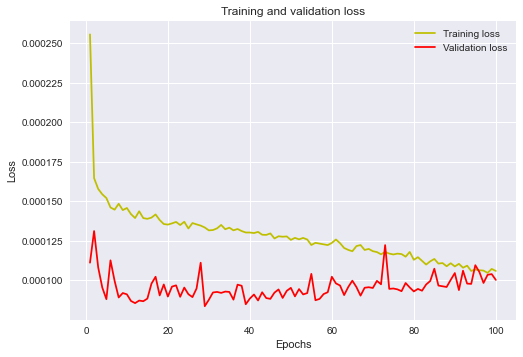

 73%|███████▎  | 73/100 [53:45<18:49, 41.83s/it]

Epoch 1/100
119/119 [==============================] - 1s 5ms/step - loss: 2.0954e-04 - mean_absolute_error: 0.0105 - val_loss: 1.4083e-04 - val_mean_absolute_error: 0.0087
Epoch 2/100
119/119 [==============================] - 0s 4ms/step - loss: 1.7336e-04 - mean_absolute_error: 0.0096 - val_loss: 9.3553e-05 - val_mean_absolute_error: 0.0068
Epoch 3/100
119/119 [==============================] - 0s 3ms/step - loss: 1.5761e-04 - mean_absolute_error: 0.0092 - val_loss: 9.9133e-05 - val_mean_absolute_error: 0.0071
Epoch 4/100
119/119 [==============================] - 0s 3ms/step - loss: 1.5691e-04 - mean_absolute_error: 0.0091 - val_loss: 1.0242e-04 - val_mean_absolute_error: 0.0072
Epoch 5/100
119/119 [==============================] - 0s 3ms/step - loss: 1.5029e-04 - mean_absolute_error: 0.0089 - val_loss: 8.6533e-05 - val_mean_absolute_error: 0.0065
Epoch 6/100
119/119 [==============================] - 0s 3ms/step - loss: 1.4764e-04 - mean_absolute_error: 0.0088 - val_loss: 9.4924e

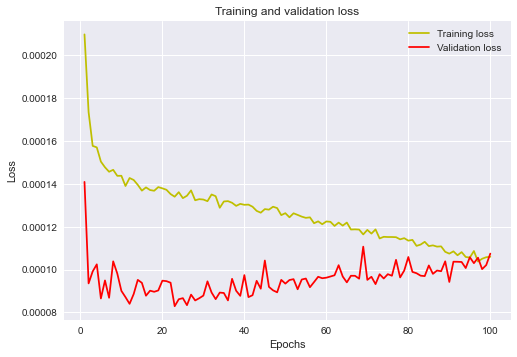

 74%|███████▍  | 74/100 [54:26<17:57, 41.45s/it]

Epoch 1/100
119/119 [==============================] - 1s 5ms/step - loss: 5.0472e-04 - mean_absolute_error: 0.0137 - val_loss: 1.0001e-04 - val_mean_absolute_error: 0.0072
Epoch 2/100
119/119 [==============================] - 0s 4ms/step - loss: 1.5733e-04 - mean_absolute_error: 0.0091 - val_loss: 9.3318e-05 - val_mean_absolute_error: 0.0069
Epoch 3/100
119/119 [==============================] - 0s 3ms/step - loss: 1.4793e-04 - mean_absolute_error: 0.0088 - val_loss: 9.0646e-05 - val_mean_absolute_error: 0.0066
Epoch 4/100
119/119 [==============================] - 0s 3ms/step - loss: 1.4785e-04 - mean_absolute_error: 0.0088 - val_loss: 9.6714e-05 - val_mean_absolute_error: 0.0070
Epoch 5/100
119/119 [==============================] - 0s 3ms/step - loss: 1.4403e-04 - mean_absolute_error: 0.0087 - val_loss: 8.5343e-05 - val_mean_absolute_error: 0.0064
Epoch 6/100
119/119 [==============================] - 0s 3ms/step - loss: 1.4394e-04 - mean_absolute_error: 0.0088 - val_loss: 1.0655e

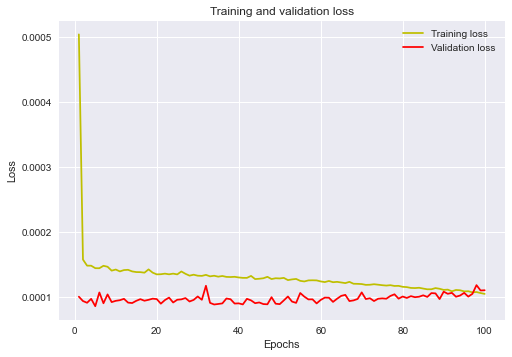

 75%|███████▌  | 75/100 [55:07<17:15, 41.44s/it]

Epoch 1/100
119/119 [==============================] - 1s 5ms/step - loss: 1.9904e-04 - mean_absolute_error: 0.0104 - val_loss: 1.1100e-04 - val_mean_absolute_error: 0.0077
Epoch 2/100
119/119 [==============================] - 0s 4ms/step - loss: 1.6411e-04 - mean_absolute_error: 0.0094 - val_loss: 1.6823e-04 - val_mean_absolute_error: 0.0099
Epoch 3/100
119/119 [==============================] - 0s 3ms/step - loss: 1.6146e-04 - mean_absolute_error: 0.0092 - val_loss: 1.0338e-04 - val_mean_absolute_error: 0.0072
Epoch 4/100
119/119 [==============================] - 0s 3ms/step - loss: 1.5410e-04 - mean_absolute_error: 0.0090 - val_loss: 1.0102e-04 - val_mean_absolute_error: 0.0071
Epoch 5/100
119/119 [==============================] - 0s 3ms/step - loss: 1.5548e-04 - mean_absolute_error: 0.0090 - val_loss: 1.8214e-04 - val_mean_absolute_error: 0.0111
Epoch 6/100
119/119 [==============================] - 0s 3ms/step - loss: 1.5306e-04 - mean_absolute_error: 0.0090 - val_loss: 8.8278e

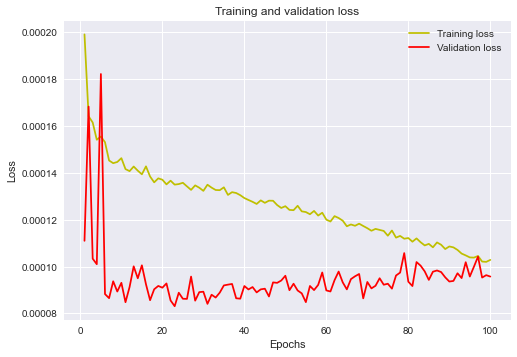

 76%|███████▌  | 76/100 [55:49<16:34, 41.46s/it]

Epoch 1/100
119/119 [==============================] - 1s 5ms/step - loss: 2.2890e-04 - mean_absolute_error: 0.0106 - val_loss: 1.8527e-04 - val_mean_absolute_error: 0.0110
Epoch 2/100
119/119 [==============================] - 0s 4ms/step - loss: 1.6960e-04 - mean_absolute_error: 0.0095 - val_loss: 1.5441e-04 - val_mean_absolute_error: 0.0098
Epoch 3/100
119/119 [==============================] - 0s 3ms/step - loss: 1.5486e-04 - mean_absolute_error: 0.0091 - val_loss: 9.9322e-05 - val_mean_absolute_error: 0.0070
Epoch 4/100
119/119 [==============================] - 0s 3ms/step - loss: 1.5422e-04 - mean_absolute_error: 0.0090 - val_loss: 9.8614e-05 - val_mean_absolute_error: 0.0071
Epoch 5/100
119/119 [==============================] - 0s 3ms/step - loss: 1.5355e-04 - mean_absolute_error: 0.0090 - val_loss: 9.6483e-05 - val_mean_absolute_error: 0.0069
Epoch 6/100
119/119 [==============================] - 0s 3ms/step - loss: 1.4714e-04 - mean_absolute_error: 0.0088 - val_loss: 1.0918e

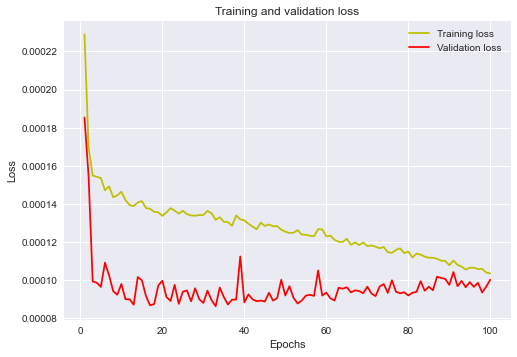

 77%|███████▋  | 77/100 [56:30<15:54, 41.50s/it]

Epoch 1/100
119/119 [==============================] - 1s 6ms/step - loss: 1.9797e-04 - mean_absolute_error: 0.0102 - val_loss: 1.0556e-04 - val_mean_absolute_error: 0.0075
Epoch 2/100
119/119 [==============================] - 0s 4ms/step - loss: 1.5994e-04 - mean_absolute_error: 0.0092 - val_loss: 1.5160e-04 - val_mean_absolute_error: 0.0085
Epoch 3/100
119/119 [==============================] - 0s 3ms/step - loss: 1.5399e-04 - mean_absolute_error: 0.0090 - val_loss: 1.0078e-04 - val_mean_absolute_error: 0.0073
Epoch 4/100
119/119 [==============================] - 0s 3ms/step - loss: 1.5036e-04 - mean_absolute_error: 0.0088 - val_loss: 1.0046e-04 - val_mean_absolute_error: 0.0072
Epoch 5/100
119/119 [==============================] - 0s 3ms/step - loss: 1.4543e-04 - mean_absolute_error: 0.0088 - val_loss: 9.2259e-05 - val_mean_absolute_error: 0.0068
Epoch 6/100
119/119 [==============================] - 0s 3ms/step - loss: 1.4985e-04 - mean_absolute_error: 0.0089 - val_loss: 8.7467e

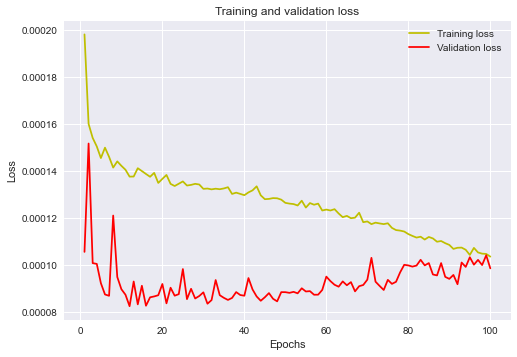

 78%|███████▊  | 78/100 [57:11<15:08, 41.30s/it]

Epoch 1/100
119/119 [==============================] - 1s 5ms/step - loss: 1.8510e-04 - mean_absolute_error: 0.0098 - val_loss: 9.0902e-05 - val_mean_absolute_error: 0.0067
Epoch 2/100
119/119 [==============================] - 0s 4ms/step - loss: 1.5513e-04 - mean_absolute_error: 0.0091 - val_loss: 9.0410e-05 - val_mean_absolute_error: 0.0067
Epoch 3/100
119/119 [==============================] - 0s 3ms/step - loss: 1.4945e-04 - mean_absolute_error: 0.0089 - val_loss: 1.1617e-04 - val_mean_absolute_error: 0.0077
Epoch 4/100
119/119 [==============================] - 0s 3ms/step - loss: 1.4968e-04 - mean_absolute_error: 0.0089 - val_loss: 8.4065e-05 - val_mean_absolute_error: 0.0064
Epoch 5/100
119/119 [==============================] - 0s 3ms/step - loss: 1.4560e-04 - mean_absolute_error: 0.0087 - val_loss: 9.0320e-05 - val_mean_absolute_error: 0.0065
Epoch 6/100
119/119 [==============================] - 0s 3ms/step - loss: 1.4506e-04 - mean_absolute_error: 0.0087 - val_loss: 9.1890e

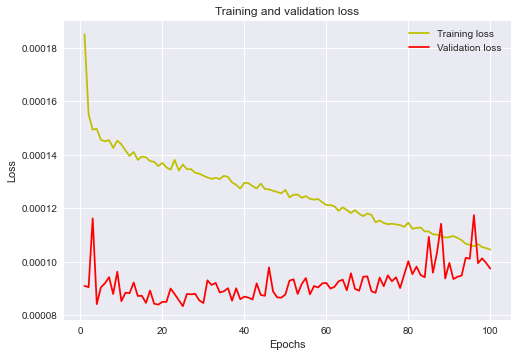

 79%|███████▉  | 79/100 [57:53<14:27, 41.33s/it]

Epoch 1/100
119/119 [==============================] - 1s 5ms/step - loss: 2.2611e-04 - mean_absolute_error: 0.0108 - val_loss: 1.0114e-04 - val_mean_absolute_error: 0.0070
Epoch 2/100
119/119 [==============================] - 0s 4ms/step - loss: 1.6238e-04 - mean_absolute_error: 0.0092 - val_loss: 9.4541e-05 - val_mean_absolute_error: 0.0069
Epoch 3/100
119/119 [==============================] - 0s 3ms/step - loss: 1.5252e-04 - mean_absolute_error: 0.0091 - val_loss: 1.3150e-04 - val_mean_absolute_error: 0.0081
Epoch 4/100
119/119 [==============================] - 0s 3ms/step - loss: 1.5803e-04 - mean_absolute_error: 0.0092 - val_loss: 8.9459e-05 - val_mean_absolute_error: 0.0065
Epoch 5/100
119/119 [==============================] - 0s 3ms/step - loss: 1.5119e-04 - mean_absolute_error: 0.0089 - val_loss: 9.5560e-05 - val_mean_absolute_error: 0.0069
Epoch 6/100
119/119 [==============================] - 0s 3ms/step - loss: 1.4991e-04 - mean_absolute_error: 0.0088 - val_loss: 8.8220e

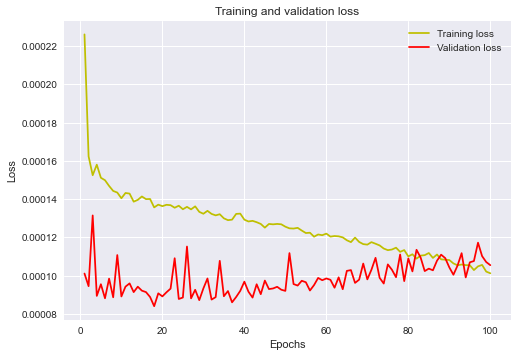

 80%|████████  | 80/100 [58:34<13:43, 41.18s/it]

Epoch 1/100
119/119 [==============================] - 1s 5ms/step - loss: 1.9917e-04 - mean_absolute_error: 0.0104 - val_loss: 1.2348e-04 - val_mean_absolute_error: 0.0071
Epoch 2/100
119/119 [==============================] - 0s 4ms/step - loss: 1.7547e-04 - mean_absolute_error: 0.0097 - val_loss: 8.4844e-05 - val_mean_absolute_error: 0.0064
Epoch 3/100
119/119 [==============================] - 0s 3ms/step - loss: 1.6207e-04 - mean_absolute_error: 0.0093 - val_loss: 9.0621e-05 - val_mean_absolute_error: 0.0068
Epoch 4/100
119/119 [==============================] - 0s 3ms/step - loss: 1.5832e-04 - mean_absolute_error: 0.0092 - val_loss: 9.9778e-05 - val_mean_absolute_error: 0.0073
Epoch 5/100
119/119 [==============================] - 0s 3ms/step - loss: 1.5792e-04 - mean_absolute_error: 0.0091 - val_loss: 8.8197e-05 - val_mean_absolute_error: 0.0066
Epoch 6/100
119/119 [==============================] - 0s 3ms/step - loss: 1.4875e-04 - mean_absolute_error: 0.0089 - val_loss: 9.7327e

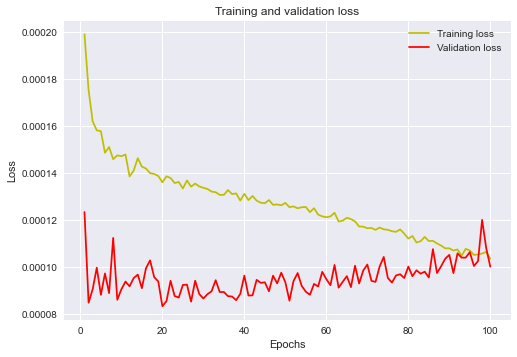

 81%|████████  | 81/100 [59:15<13:03, 41.22s/it]

Epoch 1/100
119/119 [==============================] - 1s 5ms/step - loss: 4.1893e-04 - mean_absolute_error: 0.0127 - val_loss: 9.8370e-05 - val_mean_absolute_error: 0.0069
Epoch 2/100
119/119 [==============================] - 0s 4ms/step - loss: 1.5407e-04 - mean_absolute_error: 0.0090 - val_loss: 1.0511e-04 - val_mean_absolute_error: 0.0075
Epoch 3/100
119/119 [==============================] - 0s 3ms/step - loss: 1.5066e-04 - mean_absolute_error: 0.0089 - val_loss: 8.7263e-05 - val_mean_absolute_error: 0.0066
Epoch 4/100
119/119 [==============================] - 0s 3ms/step - loss: 1.5127e-04 - mean_absolute_error: 0.0089 - val_loss: 9.0645e-05 - val_mean_absolute_error: 0.0067
Epoch 5/100
119/119 [==============================] - 0s 3ms/step - loss: 1.5286e-04 - mean_absolute_error: 0.0089 - val_loss: 1.0179e-04 - val_mean_absolute_error: 0.0073
Epoch 6/100
119/119 [==============================] - 0s 3ms/step - loss: 1.4771e-04 - mean_absolute_error: 0.0088 - val_loss: 9.2840e

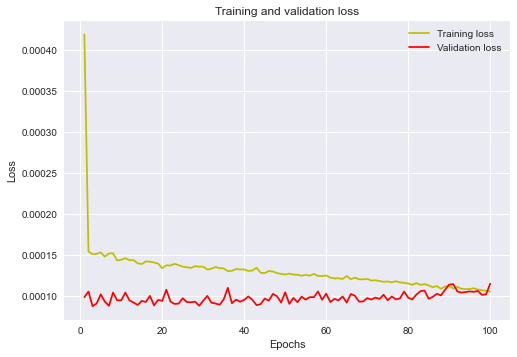

 82%|████████▏ | 82/100 [59:55<12:18, 41.01s/it]

Epoch 1/100
119/119 [==============================] - 1s 5ms/step - loss: 2.1902e-04 - mean_absolute_error: 0.0108 - val_loss: 1.0338e-04 - val_mean_absolute_error: 0.0069
Epoch 2/100
119/119 [==============================] - 0s 4ms/step - loss: 1.6675e-04 - mean_absolute_error: 0.0093 - val_loss: 1.2988e-04 - val_mean_absolute_error: 0.0085
Epoch 3/100
119/119 [==============================] - 0s 3ms/step - loss: 1.6409e-04 - mean_absolute_error: 0.0093 - val_loss: 1.4010e-04 - val_mean_absolute_error: 0.0082
Epoch 4/100
119/119 [==============================] - 0s 3ms/step - loss: 1.5757e-04 - mean_absolute_error: 0.0092 - val_loss: 1.0826e-04 - val_mean_absolute_error: 0.0069
Epoch 5/100
119/119 [==============================] - 0s 3ms/step - loss: 1.4983e-04 - mean_absolute_error: 0.0089 - val_loss: 1.0120e-04 - val_mean_absolute_error: 0.0072
Epoch 6/100
119/119 [==============================] - 0s 3ms/step - loss: 1.5116e-04 - mean_absolute_error: 0.0090 - val_loss: 1.0073e

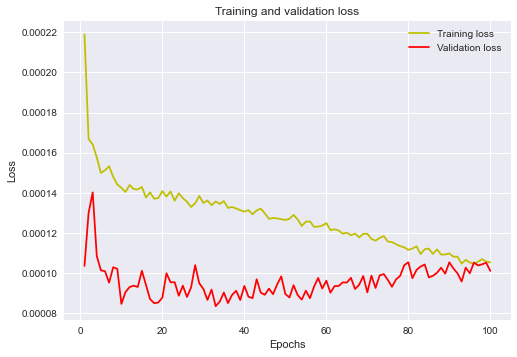

 83%|████████▎ | 83/100 [1:00:36<11:37, 41.02s/it]

Epoch 1/100
119/119 [==============================] - 1s 5ms/step - loss: 1.9808e-04 - mean_absolute_error: 0.0102 - val_loss: 1.2636e-04 - val_mean_absolute_error: 0.0079
Epoch 2/100
119/119 [==============================] - 0s 3ms/step - loss: 1.6589e-04 - mean_absolute_error: 0.0094 - val_loss: 1.0097e-04 - val_mean_absolute_error: 0.0069
Epoch 3/100
119/119 [==============================] - 0s 3ms/step - loss: 1.5660e-04 - mean_absolute_error: 0.0090 - val_loss: 9.6489e-05 - val_mean_absolute_error: 0.0070
Epoch 4/100
119/119 [==============================] - 0s 3ms/step - loss: 1.5099e-04 - mean_absolute_error: 0.0089 - val_loss: 9.6975e-05 - val_mean_absolute_error: 0.0071
Epoch 5/100
119/119 [==============================] - 0s 3ms/step - loss: 1.5220e-04 - mean_absolute_error: 0.0089 - val_loss: 9.5808e-05 - val_mean_absolute_error: 0.0069
Epoch 6/100
119/119 [==============================] - 0s 3ms/step - loss: 1.4658e-04 - mean_absolute_error: 0.0088 - val_loss: 9.0994e

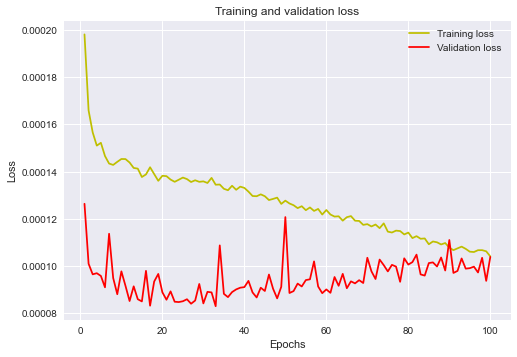

 84%|████████▍ | 84/100 [1:01:17<10:53, 40.86s/it]

Epoch 1/100
119/119 [==============================] - 1s 5ms/step - loss: 2.0281e-04 - mean_absolute_error: 0.0104 - val_loss: 1.2350e-04 - val_mean_absolute_error: 0.0082
Epoch 2/100
119/119 [==============================] - 0s 4ms/step - loss: 1.6647e-04 - mean_absolute_error: 0.0093 - val_loss: 1.0590e-04 - val_mean_absolute_error: 0.0076
Epoch 3/100
119/119 [==============================] - 0s 3ms/step - loss: 1.5777e-04 - mean_absolute_error: 0.0091 - val_loss: 8.9397e-05 - val_mean_absolute_error: 0.0065
Epoch 4/100
119/119 [==============================] - 0s 3ms/step - loss: 1.5231e-04 - mean_absolute_error: 0.0090 - val_loss: 8.7790e-05 - val_mean_absolute_error: 0.0066
Epoch 5/100
119/119 [==============================] - 0s 3ms/step - loss: 1.4981e-04 - mean_absolute_error: 0.0089 - val_loss: 9.1220e-05 - val_mean_absolute_error: 0.0067
Epoch 6/100
119/119 [==============================] - 0s 3ms/step - loss: 1.4864e-04 - mean_absolute_error: 0.0088 - val_loss: 9.3108e

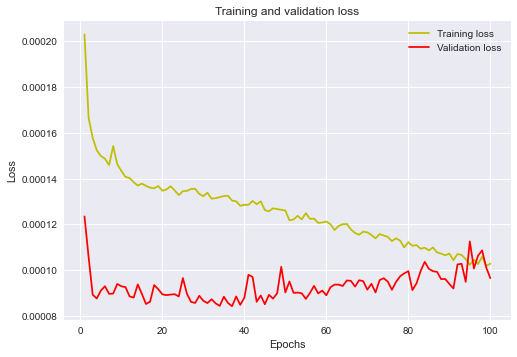

 85%|████████▌ | 85/100 [1:01:58<10:13, 40.91s/it]

Epoch 1/100
119/119 [==============================] - 1s 5ms/step - loss: 2.2168e-04 - mean_absolute_error: 0.0105 - val_loss: 1.1294e-04 - val_mean_absolute_error: 0.0077
Epoch 2/100
119/119 [==============================] - 0s 3ms/step - loss: 1.6485e-04 - mean_absolute_error: 0.0093 - val_loss: 1.5200e-04 - val_mean_absolute_error: 0.0095
Epoch 3/100
119/119 [==============================] - 0s 3ms/step - loss: 1.6149e-04 - mean_absolute_error: 0.0092 - val_loss: 9.4382e-05 - val_mean_absolute_error: 0.0069
Epoch 4/100
119/119 [==============================] - 0s 3ms/step - loss: 1.5581e-04 - mean_absolute_error: 0.0090 - val_loss: 9.4951e-05 - val_mean_absolute_error: 0.0066
Epoch 5/100
119/119 [==============================] - 0s 3ms/step - loss: 1.5544e-04 - mean_absolute_error: 0.0091 - val_loss: 9.1144e-05 - val_mean_absolute_error: 0.0066
Epoch 6/100
119/119 [==============================] - 0s 3ms/step - loss: 1.5468e-04 - mean_absolute_error: 0.0090 - val_loss: 9.7638e

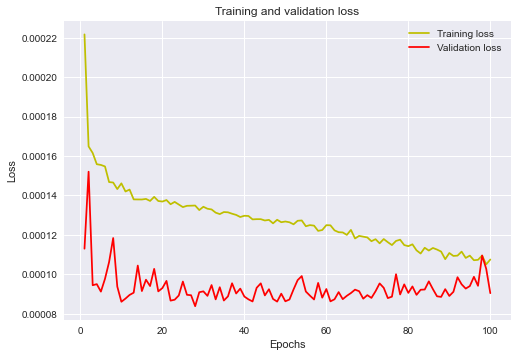

 86%|████████▌ | 86/100 [1:02:39<09:31, 40.82s/it]

Epoch 1/100
119/119 [==============================] - 1s 5ms/step - loss: 2.1681e-04 - mean_absolute_error: 0.0106 - val_loss: 1.5025e-04 - val_mean_absolute_error: 0.0088
Epoch 2/100
119/119 [==============================] - 0s 4ms/step - loss: 1.6842e-04 - mean_absolute_error: 0.0094 - val_loss: 1.0623e-04 - val_mean_absolute_error: 0.0075
Epoch 3/100
119/119 [==============================] - 0s 3ms/step - loss: 1.6141e-04 - mean_absolute_error: 0.0092 - val_loss: 1.0441e-04 - val_mean_absolute_error: 0.0070
Epoch 4/100
119/119 [==============================] - 0s 3ms/step - loss: 1.5723e-04 - mean_absolute_error: 0.0091 - val_loss: 1.0968e-04 - val_mean_absolute_error: 0.0073
Epoch 5/100
119/119 [==============================] - 0s 3ms/step - loss: 1.4998e-04 - mean_absolute_error: 0.0089 - val_loss: 9.6608e-05 - val_mean_absolute_error: 0.0067
Epoch 6/100
119/119 [==============================] - 0s 3ms/step - loss: 1.4917e-04 - mean_absolute_error: 0.0088 - val_loss: 9.1454e

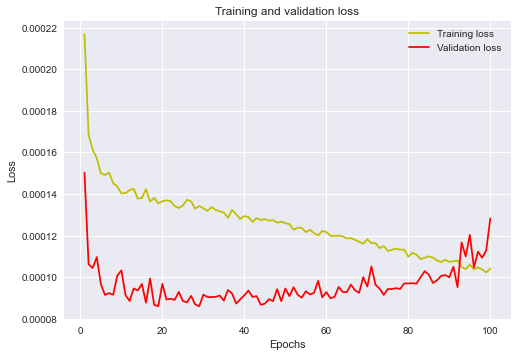

 87%|████████▋ | 87/100 [1:03:19<08:50, 40.81s/it]

Epoch 1/100
119/119 [==============================] - 1s 5ms/step - loss: 2.9393e-04 - mean_absolute_error: 0.0113 - val_loss: 1.0509e-04 - val_mean_absolute_error: 0.0074
Epoch 2/100
119/119 [==============================] - 1s 4ms/step - loss: 1.5931e-04 - mean_absolute_error: 0.0092 - val_loss: 9.0514e-05 - val_mean_absolute_error: 0.0066
Epoch 3/100
119/119 [==============================] - 0s 4ms/step - loss: 1.5464e-04 - mean_absolute_error: 0.0090 - val_loss: 1.0001e-04 - val_mean_absolute_error: 0.0070
Epoch 4/100
119/119 [==============================] - 0s 3ms/step - loss: 1.5215e-04 - mean_absolute_error: 0.0090 - val_loss: 1.0482e-04 - val_mean_absolute_error: 0.0071
Epoch 5/100
119/119 [==============================] - 0s 3ms/step - loss: 1.5022e-04 - mean_absolute_error: 0.0088 - val_loss: 8.6534e-05 - val_mean_absolute_error: 0.0064
Epoch 6/100
119/119 [==============================] - 0s 3ms/step - loss: 1.5024e-04 - mean_absolute_error: 0.0088 - val_loss: 8.8491e

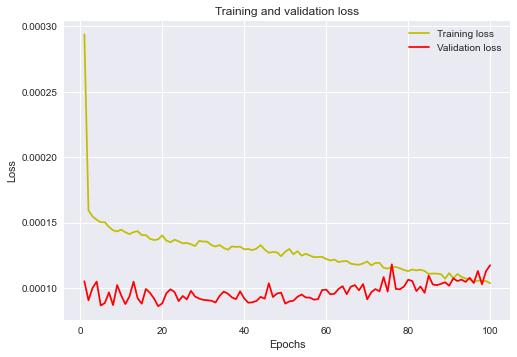

 88%|████████▊ | 88/100 [1:04:00<08:09, 40.81s/it]

Epoch 1/100
119/119 [==============================] - 1s 5ms/step - loss: 2.1784e-04 - mean_absolute_error: 0.0106 - val_loss: 1.0204e-04 - val_mean_absolute_error: 0.0073
Epoch 2/100
119/119 [==============================] - 0s 4ms/step - loss: 1.6532e-04 - mean_absolute_error: 0.0092 - val_loss: 9.4985e-05 - val_mean_absolute_error: 0.0070
Epoch 3/100
119/119 [==============================] - 0s 3ms/step - loss: 1.6045e-04 - mean_absolute_error: 0.0092 - val_loss: 1.2575e-04 - val_mean_absolute_error: 0.0083
Epoch 4/100
119/119 [==============================] - 0s 3ms/step - loss: 1.5745e-04 - mean_absolute_error: 0.0092 - val_loss: 1.1160e-04 - val_mean_absolute_error: 0.0076
Epoch 5/100
119/119 [==============================] - 0s 3ms/step - loss: 1.4899e-04 - mean_absolute_error: 0.0089 - val_loss: 9.0400e-05 - val_mean_absolute_error: 0.0067
Epoch 6/100
119/119 [==============================] - 0s 3ms/step - loss: 1.4574e-04 - mean_absolute_error: 0.0088 - val_loss: 9.5537e

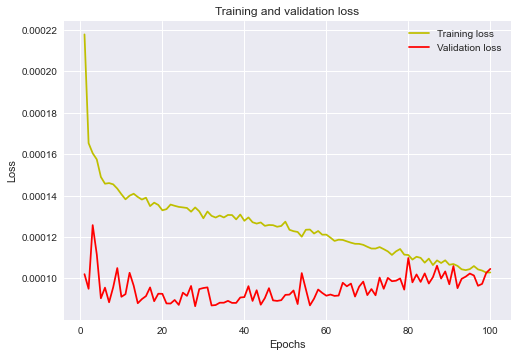

 89%|████████▉ | 89/100 [1:04:41<07:28, 40.78s/it]

Epoch 1/100
119/119 [==============================] - 1s 5ms/step - loss: 2.2457e-04 - mean_absolute_error: 0.0109 - val_loss: 1.2602e-04 - val_mean_absolute_error: 0.0084
Epoch 2/100
119/119 [==============================] - 0s 4ms/step - loss: 1.6062e-04 - mean_absolute_error: 0.0092 - val_loss: 9.4879e-05 - val_mean_absolute_error: 0.0071
Epoch 3/100
119/119 [==============================] - 0s 3ms/step - loss: 1.5477e-04 - mean_absolute_error: 0.0091 - val_loss: 8.7371e-05 - val_mean_absolute_error: 0.0066
Epoch 4/100
119/119 [==============================] - 0s 3ms/step - loss: 1.5322e-04 - mean_absolute_error: 0.0090 - val_loss: 9.4776e-05 - val_mean_absolute_error: 0.0069
Epoch 5/100
119/119 [==============================] - 0s 3ms/step - loss: 1.4702e-04 - mean_absolute_error: 0.0089 - val_loss: 9.3738e-05 - val_mean_absolute_error: 0.0067
Epoch 6/100
119/119 [==============================] - 0s 3ms/step - loss: 1.4273e-04 - mean_absolute_error: 0.0088 - val_loss: 1.1543e

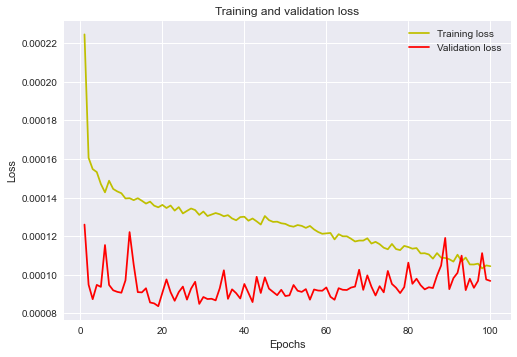

 90%|█████████ | 90/100 [1:05:22<06:48, 40.82s/it]

Epoch 1/100
119/119 [==============================] - 1s 5ms/step - loss: 2.0399e-04 - mean_absolute_error: 0.0103 - val_loss: 9.6587e-05 - val_mean_absolute_error: 0.0072
Epoch 2/100
119/119 [==============================] - 0s 4ms/step - loss: 1.6722e-04 - mean_absolute_error: 0.0094 - val_loss: 1.1357e-04 - val_mean_absolute_error: 0.0075
Epoch 3/100
119/119 [==============================] - 0s 3ms/step - loss: 1.5821e-04 - mean_absolute_error: 0.0092 - val_loss: 1.4377e-04 - val_mean_absolute_error: 0.0088
Epoch 4/100
119/119 [==============================] - 0s 3ms/step - loss: 1.5925e-04 - mean_absolute_error: 0.0092 - val_loss: 1.2003e-04 - val_mean_absolute_error: 0.0083
Epoch 5/100
119/119 [==============================] - 0s 3ms/step - loss: 1.4861e-04 - mean_absolute_error: 0.0089 - val_loss: 1.0901e-04 - val_mean_absolute_error: 0.0077
Epoch 6/100
119/119 [==============================] - 0s 4ms/step - loss: 1.4744e-04 - mean_absolute_error: 0.0088 - val_loss: 1.0026e

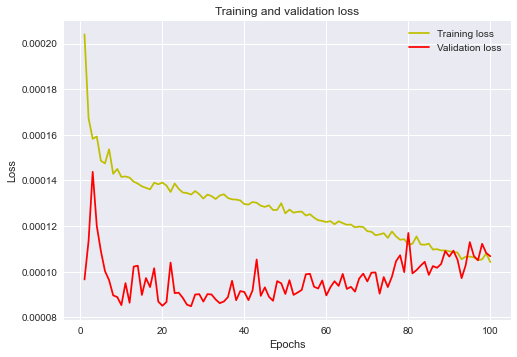

 91%|█████████ | 91/100 [1:06:03<06:09, 41.08s/it]

Epoch 1/100
119/119 [==============================] - 1s 5ms/step - loss: 2.4727e-04 - mean_absolute_error: 0.0113 - val_loss: 1.3245e-04 - val_mean_absolute_error: 0.0085
Epoch 2/100
119/119 [==============================] - 0s 4ms/step - loss: 1.8076e-04 - mean_absolute_error: 0.0099 - val_loss: 9.7435e-05 - val_mean_absolute_error: 0.0071
Epoch 3/100
119/119 [==============================] - 0s 3ms/step - loss: 1.6760e-04 - mean_absolute_error: 0.0095 - val_loss: 9.7944e-05 - val_mean_absolute_error: 0.0068
Epoch 4/100
119/119 [==============================] - 0s 3ms/step - loss: 1.5749e-04 - mean_absolute_error: 0.0092 - val_loss: 1.1361e-04 - val_mean_absolute_error: 0.0079
Epoch 5/100
119/119 [==============================] - 0s 3ms/step - loss: 1.5112e-04 - mean_absolute_error: 0.0090 - val_loss: 1.0044e-04 - val_mean_absolute_error: 0.0069
Epoch 6/100
119/119 [==============================] - 0s 3ms/step - loss: 1.5525e-04 - mean_absolute_error: 0.0092 - val_loss: 1.0463e

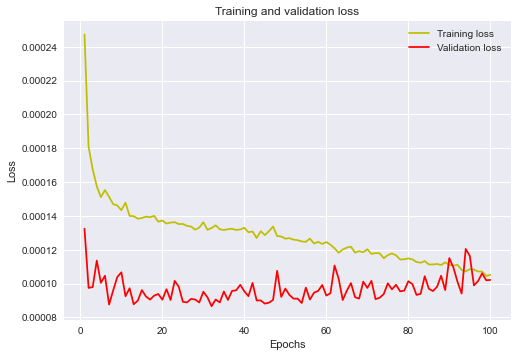

 92%|█████████▏| 92/100 [1:06:47<05:35, 41.88s/it]

Epoch 1/100
119/119 [==============================] - 1s 6ms/step - loss: 2.4178e-04 - mean_absolute_error: 0.0111 - val_loss: 9.2963e-05 - val_mean_absolute_error: 0.0066
Epoch 2/100
119/119 [==============================] - 0s 4ms/step - loss: 1.6013e-04 - mean_absolute_error: 0.0092 - val_loss: 1.0973e-04 - val_mean_absolute_error: 0.0076
Epoch 3/100
119/119 [==============================] - 0s 4ms/step - loss: 1.5138e-04 - mean_absolute_error: 0.0089 - val_loss: 9.9511e-05 - val_mean_absolute_error: 0.0072
Epoch 4/100
119/119 [==============================] - 0s 3ms/step - loss: 1.4661e-04 - mean_absolute_error: 0.0088 - val_loss: 9.2674e-05 - val_mean_absolute_error: 0.0068
Epoch 5/100
119/119 [==============================] - 0s 3ms/step - loss: 1.4843e-04 - mean_absolute_error: 0.0089 - val_loss: 9.5268e-05 - val_mean_absolute_error: 0.0069
Epoch 6/100
119/119 [==============================] - 0s 4ms/step - loss: 1.5080e-04 - mean_absolute_error: 0.0089 - val_loss: 9.6381e

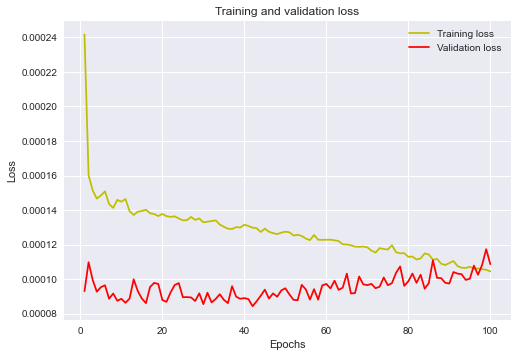

 93%|█████████▎| 93/100 [1:07:30<04:56, 42.31s/it]

Epoch 1/100
119/119 [==============================] - 1s 5ms/step - loss: 3.1754e-04 - mean_absolute_error: 0.0121 - val_loss: 1.1222e-04 - val_mean_absolute_error: 0.0076
Epoch 2/100
119/119 [==============================] - 0s 4ms/step - loss: 1.5423e-04 - mean_absolute_error: 0.0090 - val_loss: 1.0329e-04 - val_mean_absolute_error: 0.0074
Epoch 3/100
119/119 [==============================] - 0s 3ms/step - loss: 1.5869e-04 - mean_absolute_error: 0.0091 - val_loss: 1.0541e-04 - val_mean_absolute_error: 0.0075
Epoch 4/100
119/119 [==============================] - 0s 3ms/step - loss: 1.5957e-04 - mean_absolute_error: 0.0092 - val_loss: 1.4299e-04 - val_mean_absolute_error: 0.0087
Epoch 5/100
119/119 [==============================] - 0s 3ms/step - loss: 1.5016e-04 - mean_absolute_error: 0.0090 - val_loss: 1.0240e-04 - val_mean_absolute_error: 0.0071
Epoch 6/100
119/119 [==============================] - 0s 3ms/step - loss: 1.4819e-04 - mean_absolute_error: 0.0089 - val_loss: 9.2230e

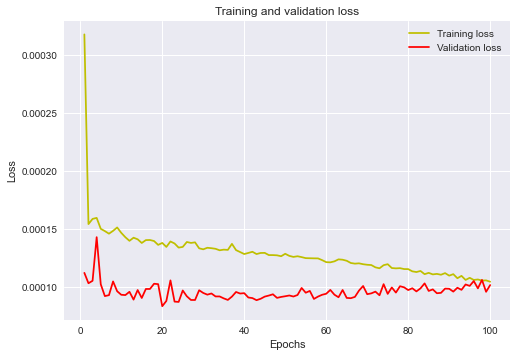

 94%|█████████▍| 94/100 [1:08:14<04:16, 42.72s/it]

Epoch 1/100
119/119 [==============================] - 1s 5ms/step - loss: 2.1625e-04 - mean_absolute_error: 0.0105 - val_loss: 1.0012e-04 - val_mean_absolute_error: 0.0071
Epoch 2/100
119/119 [==============================] - 0s 4ms/step - loss: 1.6144e-04 - mean_absolute_error: 0.0093 - val_loss: 9.4302e-05 - val_mean_absolute_error: 0.0070
Epoch 3/100
119/119 [==============================] - 0s 4ms/step - loss: 1.5950e-04 - mean_absolute_error: 0.0093 - val_loss: 1.1480e-04 - val_mean_absolute_error: 0.0076
Epoch 4/100
119/119 [==============================] - 0s 3ms/step - loss: 1.6061e-04 - mean_absolute_error: 0.0092 - val_loss: 9.6426e-05 - val_mean_absolute_error: 0.0071
Epoch 5/100
119/119 [==============================] - 0s 4ms/step - loss: 1.5316e-04 - mean_absolute_error: 0.0090 - val_loss: 1.0291e-04 - val_mean_absolute_error: 0.0068
Epoch 6/100
119/119 [==============================] - 0s 3ms/step - loss: 1.5184e-04 - mean_absolute_error: 0.0089 - val_loss: 1.3371e

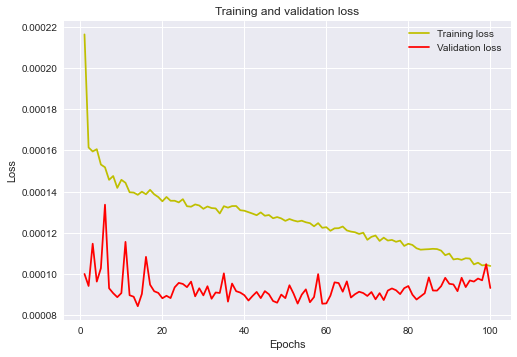

 95%|█████████▌| 95/100 [1:08:58<03:34, 42.91s/it]

Epoch 1/100
119/119 [==============================] - 1s 5ms/step - loss: 2.2005e-04 - mean_absolute_error: 0.0107 - val_loss: 1.0748e-04 - val_mean_absolute_error: 0.0074
Epoch 2/100
119/119 [==============================] - 0s 4ms/step - loss: 1.7229e-04 - mean_absolute_error: 0.0097 - val_loss: 9.2884e-05 - val_mean_absolute_error: 0.0067
Epoch 3/100
119/119 [==============================] - 0s 4ms/step - loss: 1.6535e-04 - mean_absolute_error: 0.0093 - val_loss: 1.2216e-04 - val_mean_absolute_error: 0.0079
Epoch 4/100
119/119 [==============================] - 0s 3ms/step - loss: 1.5824e-04 - mean_absolute_error: 0.0092 - val_loss: 1.5860e-04 - val_mean_absolute_error: 0.0094
Epoch 5/100
119/119 [==============================] - 0s 3ms/step - loss: 1.5569e-04 - mean_absolute_error: 0.0091 - val_loss: 8.9113e-05 - val_mean_absolute_error: 0.0067
Epoch 6/100
119/119 [==============================] - 0s 4ms/step - loss: 1.4962e-04 - mean_absolute_error: 0.0090 - val_loss: 1.2338e

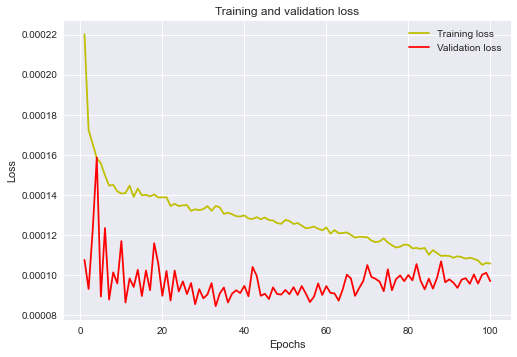

 96%|█████████▌| 96/100 [1:09:39<02:50, 42.57s/it]

Epoch 1/100
119/119 [==============================] - 1s 6ms/step - loss: 2.1025e-04 - mean_absolute_error: 0.0106 - val_loss: 1.0672e-04 - val_mean_absolute_error: 0.0076
Epoch 2/100
119/119 [==============================] - 0s 4ms/step - loss: 1.6176e-04 - mean_absolute_error: 0.0093 - val_loss: 1.1694e-04 - val_mean_absolute_error: 0.0078
Epoch 3/100
119/119 [==============================] - 0s 3ms/step - loss: 1.6465e-04 - mean_absolute_error: 0.0094 - val_loss: 9.7491e-05 - val_mean_absolute_error: 0.0070
Epoch 4/100
119/119 [==============================] - 0s 3ms/step - loss: 1.5793e-04 - mean_absolute_error: 0.0091 - val_loss: 9.5753e-05 - val_mean_absolute_error: 0.0069
Epoch 5/100
119/119 [==============================] - 0s 3ms/step - loss: 1.5034e-04 - mean_absolute_error: 0.0089 - val_loss: 9.1787e-05 - val_mean_absolute_error: 0.0067
Epoch 6/100
119/119 [==============================] - 0s 3ms/step - loss: 1.4746e-04 - mean_absolute_error: 0.0089 - val_loss: 9.9062e

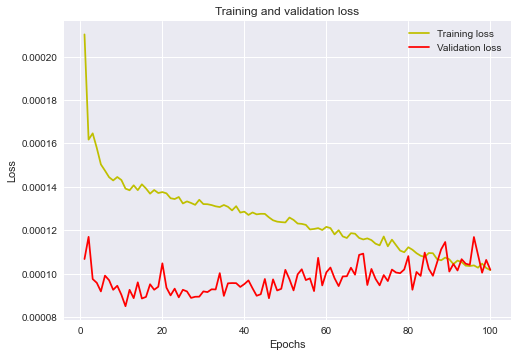

 97%|█████████▋| 97/100 [1:10:21<02:06, 42.16s/it]

Epoch 1/100
119/119 [==============================] - 1s 5ms/step - loss: 2.5277e-04 - mean_absolute_error: 0.0114 - val_loss: 1.0729e-04 - val_mean_absolute_error: 0.0074
Epoch 2/100
119/119 [==============================] - 0s 4ms/step - loss: 1.7052e-04 - mean_absolute_error: 0.0096 - val_loss: 1.3796e-04 - val_mean_absolute_error: 0.0088
Epoch 3/100
119/119 [==============================] - 0s 3ms/step - loss: 1.6284e-04 - mean_absolute_error: 0.0093 - val_loss: 1.1512e-04 - val_mean_absolute_error: 0.0074
Epoch 4/100
119/119 [==============================] - 0s 3ms/step - loss: 1.6196e-04 - mean_absolute_error: 0.0092 - val_loss: 1.0314e-04 - val_mean_absolute_error: 0.0068
Epoch 5/100
119/119 [==============================] - 0s 3ms/step - loss: 1.6126e-04 - mean_absolute_error: 0.0092 - val_loss: 1.2299e-04 - val_mean_absolute_error: 0.0073
Epoch 6/100
119/119 [==============================] - 0s 3ms/step - loss: 1.5929e-04 - mean_absolute_error: 0.0090 - val_loss: 1.1602e

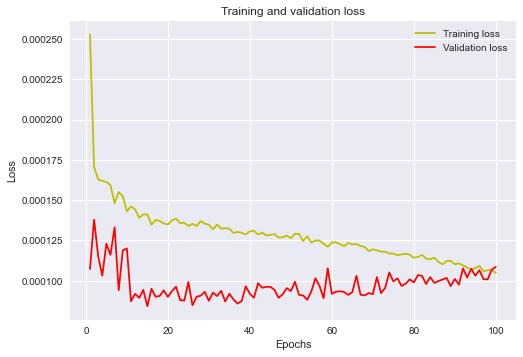

 98%|█████████▊| 98/100 [1:11:01<01:23, 41.78s/it]

Epoch 1/100
119/119 [==============================] - 1s 6ms/step - loss: 2.2048e-04 - mean_absolute_error: 0.0108 - val_loss: 1.2640e-04 - val_mean_absolute_error: 0.0077
Epoch 2/100
119/119 [==============================] - 0s 4ms/step - loss: 1.6716e-04 - mean_absolute_error: 0.0094 - val_loss: 1.1442e-04 - val_mean_absolute_error: 0.0079
Epoch 3/100
119/119 [==============================] - 0s 3ms/step - loss: 1.5971e-04 - mean_absolute_error: 0.0092 - val_loss: 1.3371e-04 - val_mean_absolute_error: 0.0085
Epoch 4/100
119/119 [==============================] - 0s 3ms/step - loss: 1.5285e-04 - mean_absolute_error: 0.0090 - val_loss: 1.0202e-04 - val_mean_absolute_error: 0.0068
Epoch 5/100
119/119 [==============================] - 0s 3ms/step - loss: 1.5724e-04 - mean_absolute_error: 0.0091 - val_loss: 9.2725e-05 - val_mean_absolute_error: 0.0067
Epoch 6/100
119/119 [==============================] - 0s 3ms/step - loss: 1.5384e-04 - mean_absolute_error: 0.0092 - val_loss: 9.2469e

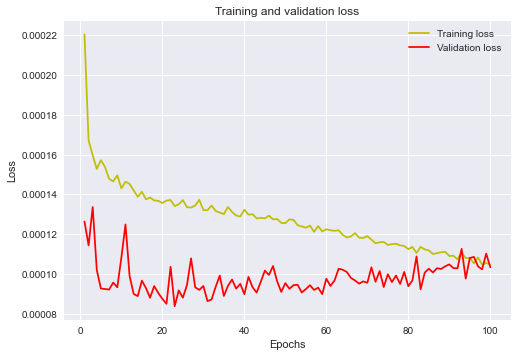

 99%|█████████▉| 99/100 [1:11:43<00:41, 41.60s/it]

Epoch 1/100
119/119 [==============================] - 1s 5ms/step - loss: 3.2014e-04 - mean_absolute_error: 0.0123 - val_loss: 1.1734e-04 - val_mean_absolute_error: 0.0076
Epoch 2/100
119/119 [==============================] - 0s 4ms/step - loss: 1.6919e-04 - mean_absolute_error: 0.0094 - val_loss: 1.2982e-04 - val_mean_absolute_error: 0.0085
Epoch 3/100
119/119 [==============================] - 0s 3ms/step - loss: 1.7596e-04 - mean_absolute_error: 0.0096 - val_loss: 1.4989e-04 - val_mean_absolute_error: 0.0094
Epoch 4/100
119/119 [==============================] - 0s 3ms/step - loss: 1.5628e-04 - mean_absolute_error: 0.0092 - val_loss: 1.3952e-04 - val_mean_absolute_error: 0.0086
Epoch 5/100
119/119 [==============================] - 0s 3ms/step - loss: 1.5317e-04 - mean_absolute_error: 0.0090 - val_loss: 1.0964e-04 - val_mean_absolute_error: 0.0071
Epoch 6/100
119/119 [==============================] - 0s 3ms/step - loss: 1.5303e-04 - mean_absolute_error: 0.0090 - val_loss: 8.9897e

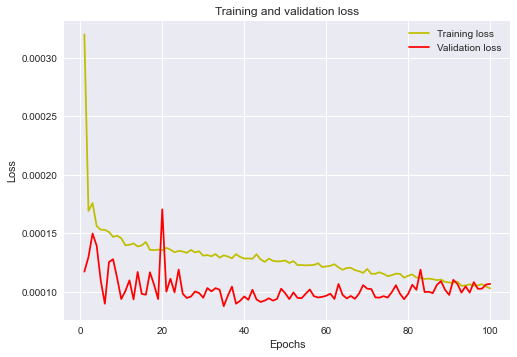

100%|██████████| 100/100 [1:12:24<00:00, 43.44s/it]


In [5]:
# library to estimate the time until the end of the loop

from tqdm import tqdm

return_test = []
return_val = []

# compute the return during the test and validation period

for i in tqdm(range(100)):
    train,val,test = build_model(symbol,price_type,split_ratio, n_neurons , n_hidden_layers, epochs, folder_name = '26July2022_test1')
    return_test.append(test)
    return_val.append(val)

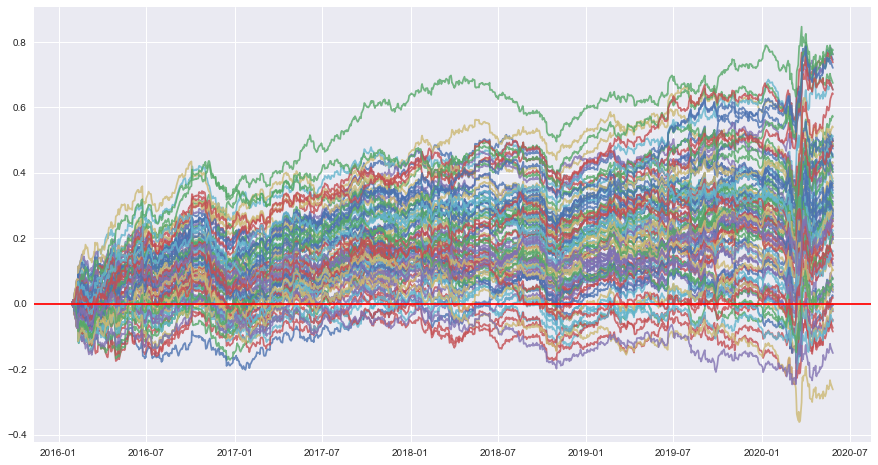

In [18]:
# Organize well all the data
model_returns = pd.DataFrame(return_val, index=[f"model_{i}" for i in range(len(return_val))]).transpose()

# Adapt the size of the graph
plt.figure(figsize=(15,8))

# Plot the returns
plt.plot(model_returns.cumsum(axis=0), alpha=0.8)

# Plot break-even line
plt.axhline(0, color="red")

# show the graph
plt.show()

In [19]:
def drawdown_function(serie):
    
  # We compute Cumsum of the returns
  cum = serie.dropna().cumsum() + 1

  # We compute max of the cumsum on the period (accumulate max) # (1,3,5,3,1) --> (1,3,5,5,5)
  running_max = np.maximum.accumulate(cum)

  # We compute drawdown
  drawdown = cum/running_max - 1
  return drawdown

In [20]:
# Create empty dataframe
values = pd.DataFrame(index=["ret/dd", "ret", "dd"])

# Compute return and max drawdawn for each ANN
for col in model_returns.columns:

  # Compute the returns and the max drawdown for one ANN
  ret, dd = model_returns[col].cumsum().iloc[-1], -np.min(drawdown_function(model_returns[col]))

  # Create a column containing the ret/dd ratio, the returns and the drawdown
  values[col] = ret/dd, ret, dd

In [24]:
values.transpose().sort_values(by="ret/dd", ascending=False)

ret/dd       ret        dd
model_21  7.806392  0.761965  0.097608
model_55  6.498176  0.774019  0.119113
model_19  6.443479  0.673940  0.104593
model_26  6.376214  0.736676  0.115535
model_79  6.073045  0.760839  0.125281
...            ...       ...       ...
model_2  -0.181779 -0.050767  0.279279
model_14 -0.288248 -0.074182  0.257355
model_74 -0.304750 -0.085549  0.280718
model_57 -0.429865 -0.151115  0.351541
model_82 -0.636534 -0.262297  0.412070

[100 rows x 3 columns]

In [21]:
models_DNN = list(values.transpose().sort_values(by="ret/dd", ascending=False).index[0:3])

In [22]:
models_DNN

['model_21', 'model_55', 'model_19']

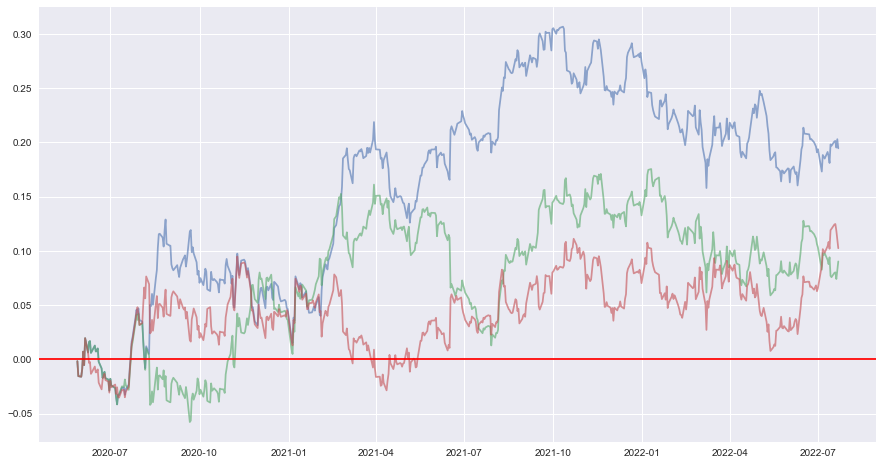

In [29]:
""" Use the 3best models on the test set to trade on the validation set"""

# Organize the data 
ANN_val = pd.DataFrame(return_test, index=[f"model_{i}" for i in range(len(return_test))]).transpose()
#print(ANN_val)
# Adapt the size
plt.figure(figsize=(15,8))

# Plot the portfolio method containing the 10 best strategies
plt.plot(ANN_val[models_DNN].cumsum(axis=0), alpha=0.6)

plt.axhline(0, color="red")

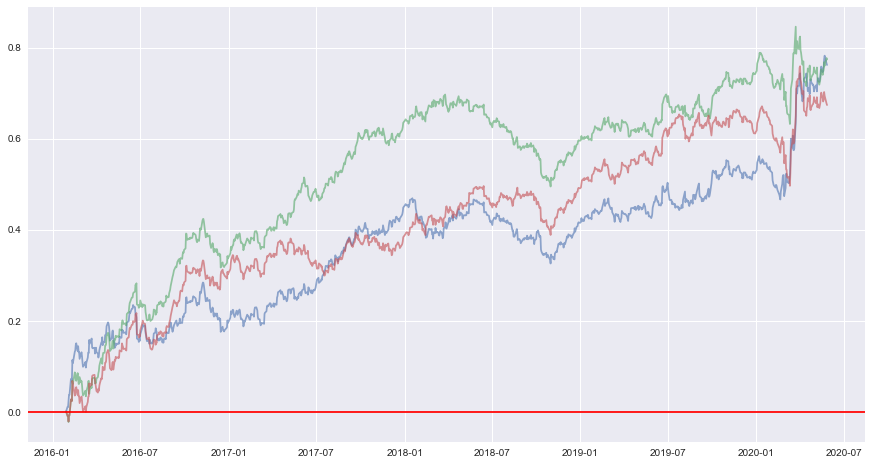

In [30]:
""" Use the 3best models on the test set to trade on the test set"""

# Organize the data 
ANN_val = pd.DataFrame(return_test, index=[f"model_{i}" for i in range(len(return_test))]).transpose()

# Adapt the size
plt.figure(figsize=(15,8))

# Plot the portfolio method containing the 10 best strategies
plt.plot(model_returns[models_DNN].cumsum(axis=0), alpha=0.6)

plt.axhline(0, color="red")

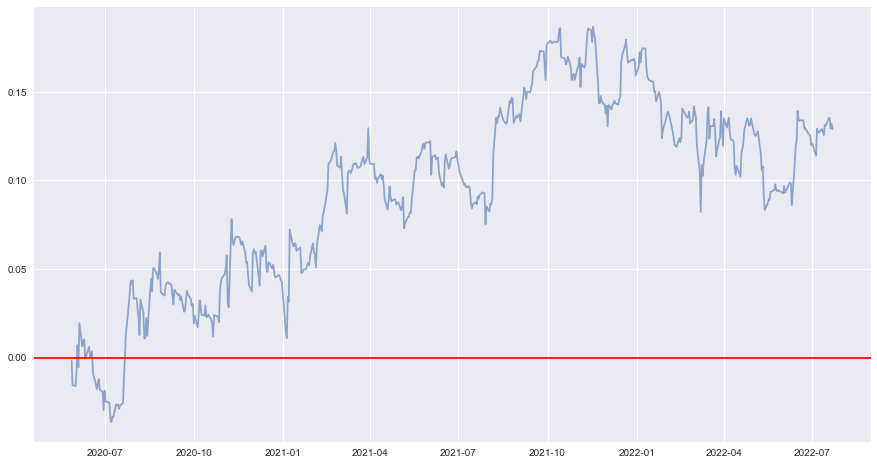

In [31]:
""" Strategy created """
# Adapt the size
plt.figure(figsize=(15,8))

# Plot the portfolio method containing the 10 best strategies
plt.plot(ANN_val[models_DNN].sum(axis=1).cumsum(axis=0)/3, alpha=0.6)
plt.axhline(0, color="red")